## 1. Import thư viện

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import obonet
import networkx as nx
from Bio import SeqIO
import os
import warnings
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import pickle
import h5py
from tqdm import tqdm
# Bỏ qua vài thông báo, có thể không quan trọng 
warnings.filterwarnings('ignore')

# Chọn style biểu đồ đẹp hơn --> Chọn kiểu cho matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
# Đổi bảng màu tươi cho sns
sns.set_palette("husl")

# config link data
BASE_DIR = "/Users/user/ML/CreatineML"
TRAIN_DIR = os.path.join(BASE_DIR, 'Train')
TEST_DIR = os.path.join(BASE_DIR, 'Test')

#check
print("Done")

Done


## 2. Load GO Ontology

In [6]:
# load GO từ file OBO
obo_file = os.path.join(TRAIN_DIR, "go-basic.obo")
# Chuyển Go thành dạng Graph
graph = obonet.read_obo(obo_file)
go_graph = graph
ROOT_TERMS = {
    'BPO': 'GO:0008150',  # Biological Process
    'CCO': 'GO:0005575',  # Cellular Component
    'MFO': 'GO:0003674'   # Molecular Function
}

# Tạo mapping từ GO ID đến namépace
go_id_to_namespace = {}
go_id_to_name = {}
go_id_to_defination = {}

for node_id, data in go_graph.nodes(data=True):
    go_id_to_namespace[node_id] = data.get('namespace', 'unknown')
    go_id_to_name[node_id] = data.get('name', '')
    go_id_to_defination[node_id] = data.get('def', '')

print(f"Tổng số GO terms: {len(go_id_to_namespace)}")
print(f"\nRoot terms:")
for ont, root_id in ROOT_TERMS.items():
    print(f"{ont}: {root_id} - {go_id_to_name.get(root_id, "N/A")}")

# Đếm số terms theo namespace
namespace_counts = Counter(go_id_to_namespace.values())
print(f"\nSố lượng terms theo namespace:")
for ns, count in namespace_counts.items():
    print(f"  {ns}: {count}")

Tổng số GO terms: 40122

Root terms:
BPO: GO:0008150 - biological_process
CCO: GO:0005575 - cellular_component
MFO: GO:0003674 - molecular_function

Số lượng terms theo namespace:
  biological_process: 25950
  molecular_function: 10131
  cellular_component: 4041


In [7]:
# Ancestors/ Descendants --> Ta sẽ lấy 2 tập này bằng BFS
def get_ancestors(go_id, graph):
    # Ta sẽ lấy full các ancestors của 1 GO term
    ancestors = set()
    queue = [go_id]
    while queue:
        current = queue.pop(0)
        if(current in ancestors):
            continue
        ancestors.add(current)
        for parent in graph.predecessors(current):
            if(parent not in ancestors):
                queue.append(parent)
    return ancestors

def get_descendants(go_id, graph):
    descendants = set()
    queue = [go_id]
    while queue:
        current = queue.pop(0)
        if current in descendants:
            continue
        descendants.add(current)
        # Lấy children
        for child in graph.successors(current):
            if child not in descendants:
                queue.append(child)
    return descendants

# Test với một GO term
test_term = 'GO:0005515'  # protein binding
ancestors = get_ancestors(test_term, go_graph)
descendants = get_descendants(test_term, go_graph)

print(f"Test term: {test_term} - {go_id_to_name.get(test_term, 'N/A')}")
print(f"Số ancestors: {len(ancestors)}")
print(f"Số descendants: {len(descendants)}")
print(f"\nMột số ancestors:")
for i, anc in enumerate(list(ancestors)[:5]):
    print(f"  {anc}: {go_id_to_name.get(anc, 'N/A')}")

print(f"\nMột số descendants:")
for i, anc in enumerate(list(descendants)[:3]):
    print(f"  {anc}: {go_id_to_name.get(anc, 'N/A')}")

Test term: GO:0005515 - protein binding
Số ancestors: 909
Số descendants: 3

Một số ancestors:
  GO:0045517: interleukin-20 receptor binding
  GO:0008267: poly-glutamine tract binding
  GO:0061676: importin-alpha family protein binding
  GO:1990309: type-II dockerin domain binding
  GO:0044198: zf-TRAF domain binding

Một số descendants:
  GO:0005515: protein binding
  GO:0005488: binding
  GO:0003674: molecular_function


## 3. Load Training Labels

In [8]:
# Load
# train_terms.tsv là nơi chưa nhãn GO thật thật cho các protein dùng để training
train_terms_file = os.path.join(TRAIN_DIR, "train_terms.tsv")
train_terms = pd.read_csv(train_terms_file, sep="\t")
print(f"shape: {train_terms.shape}")
print(f"\nVài hàng đầu: ")
print(train_terms.head(10))

print(f"\nTên cột: {train_terms.columns.tolist()}")
print(f"\nASpect distribution:{train_terms['aspect'].value_counts()}")

# Mapping aspect --> Chuyển kí tự sang fullname aspect 
## BP --> Protein tham gia quá trình sinh học nào ?
## MF --> Tác dụng trực tiếp ở mức phân tử
## CC --> Vị trí protein trong tế bào
aspect_map = {'P': 'Biological Process', 'F': 'Molecular Function', 'C':'Cellular Component'}
train_terms['aspect_name'] = train_terms['aspect'].map(aspect_map)
print(f"\nAspect distribution (names):")
print(train_terms['aspect_name'].value_counts())

shape: (537027, 3)

Vài hàng đầu: 
  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F
2  Q5W0B1  GO:0051865      P
3  Q5W0B1  GO:0006275      P
4  Q5W0B1  GO:0006513      P
5  Q5W0B1  GO:0003682      F
6  Q5W0B1  GO:0005515      F
7  Q3EC77  GO:0000138      C
8  Q3EC77  GO:0005794      C
9  Q8IZR5  GO:0005515      F

Tên cột: ['EntryID', 'term', 'aspect']

ASpect distribution:aspect
P    250805
C    157770
F    128452
Name: count, dtype: int64

Aspect distribution (names):
aspect_name
Biological Process    250805
Cellular Component    157770
Molecular Function    128452
Name: count, dtype: int64


In [9]:
# Thống kê labels
unique_proteins = train_terms['EntryID'].nunique()
unique_terms = train_terms['term'].nunique()
avg_terms_per_protein = train_terms.groupby('EntryID')['term'].count().mean()

print(f"Số lượng protein duy nhất: {unique_proteins:,}")
print(f"Số lượng GO terms duy nhất: {unique_terms:,}")
print(f"Trung bình số terms mỗi protein: {avg_terms_per_protein:.2f}")

# Phân phối của số terms trong mỗi 1 protein 
terms_per_protein = train_terms.groupby('EntryID')['term'].count()
print(f"\nThống kê -> terms_per_protein:\n{terms_per_protein.describe()}")

# BXH GO terms popular
top_terms = train_terms['term'].value_counts().head(20) #20 cháu đi
print(f"\nTop 20 phổ biến:")
for term, count in top_terms.items():
    term_name = go_id_to_name.get(term, 'N/A')
    print(f"  {term} ({term_name[:50]}): {count:,}")


Số lượng protein duy nhất: 82,404
Số lượng GO terms duy nhất: 26,125
Trung bình số terms mỗi protein: 6.52

Thống kê -> terms_per_protein:
count    82404.000000
mean         6.517002
std          7.965655
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max        233.000000
Name: term, dtype: float64

Top 20 phổ biến:
  GO:0005515 (protein binding): 33,713
  GO:0005634 (nucleus): 13,283
  GO:0005829 (cytosol): 13,040
  GO:0005886 (plasma membrane): 10,150
  GO:0005737 (cytoplasm): 9,442
  GO:0005739 (mitochondrion): 5,807
  GO:0005654 (nucleoplasm): 5,065
  GO:0016020 (membrane): 3,563
  GO:0042802 (identical protein binding): 3,547
  GO:0005576 (extracellular region): 3,241
  GO:0005783 (endoplasmic reticulum): 2,837
  GO:0005615 (extracellular space): 2,391
  GO:0045944 (positive regulation of transcription by RNA polyme): 2,319
  GO:0070062 (extracellular exosome): 2,130
  GO:0005794 (Golgi apparatus): 2,045
  GO:0005730 (nucleolus): 1,789
  G

## 4. Load Protein Sequences

In [10]:
# Load file chứa chuỗi Amino acid của các protein train
train_fasta_file = os.path.join(TRAIN_DIR, 'train_sequences.fasta')
sequences = {}
sequence_lengths = []
sample_size = 10000 #Đọc 10k sequences đầu
count = 0

for record in SeqIO.parse(train_fasta_file, "fasta"):
    if count >= sample_size:
        break
    seq_id = record.id.split("|")[1] if '|' in record.id else record.id.split()[0]
    seq = str(record.seq)
    sequences[seq_id] = seq
    sequence_lengths.append(len(seq))
    count+=1

print(f"Đã load {len(sequences):,} sequences (sample)")
print(f"Độ dài trung bình: {np.mean(sequence_lengths):.2f} amino acids")
print(f"Độ dài min: {min(sequence_lengths)}")
print(f"Độ dài max: {max(sequence_lengths)}")
print(f"Độ dài median: {np.median(sequence_lengths):.2f}")

#sample sequences
print(f"\nMột vài sequences mẫu:")
for i, (seq_id, seq) in enumerate(list(sequences.items())[:3]):
    print(f"\n{seq_id}: {seq[:100]}... (length: {len(seq)})")

print("\n")

# Đọc toàn bộ file để lấy thống kê chính xác về độ dài
all_lengths = []
total_seqs = 0

for record in SeqIO.parse(train_fasta_file, "fasta"):
    all_lengths.append(len(record.seq))
    total_seqs += 1

print(f"\nTổng số sequences: {total_seqs:,}")
print(f"Thống kê độ dài sequences:")
length_stats = pd.Series(all_lengths).describe()
print(length_stats)

Đã load 10,000 sequences (sample)
Độ dài trung bình: 611.94 amino acids
Độ dài min: 16
Độ dài max: 34350
Độ dài median: 458.00

Một vài sequences mẫu:

A0A0C5B5G6: MRWQEMGYIFYPRKLR... (length: 16)

A0JNW5: MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPTWLAINKVFCNKASIRIPWTKLKTHPICLSLDKVIMEMSTCEEPRSP... (length: 1464)

A0JP26: MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFMKTLRSKMGKCCHHCFPCCRGSGTSNVGTSGDHDNSFMKTLRSKMGK... (length: 581)



Tổng số sequences: 82,404
Thống kê độ dài sequences:
count    82404.000000
mean       525.788287
std        521.574869
min          3.000000
25%        250.000000
50%        409.000000
75%        630.000000
max      35213.000000
dtype: float64


## 5. Load Taxonomy and IA Weight

In [11]:
# Load taxonomy
taxonomy_file = os.path.join(TRAIN_DIR, 'train_taxonomy.tsv')

taxonomy = pd.read_csv(taxonomy_file, sep='\t', header=None, names=['EntryID', 'taxon_id'])
print(f"Shape: {taxonomy.shape}")
print(f"\nVài hàng đầu:")
print(taxonomy.head(10))

print(f"\nSố lượng species duy nhất: {taxonomy['taxon_id'].nunique()}")
print(f"\nTop 10 species:")
print(taxonomy['taxon_id'].value_counts().head(10))

Shape: (82404, 2)

Vài hàng đầu:
      EntryID  taxon_id
0  A0A0C5B5G6      9606
1      A0JNW5      9606
2      A0JP26      9606
3      A0PK11      9606
4      A1A4S6      9606
5      A1A519      9606
6      A1L190      9606
7      A1L3X0      9606
8      A1X283      9606
9      A2A2Y4      9606

Số lượng species duy nhất: 1381

Top 10 species:
taxon_id
9606      17162
10090     12508
3702      11863
559292     5520
10116      4909
284812     4636
83333      3466
7227       3201
6239       2540
83332      1530
Name: count, dtype: int64


In [12]:
# Load IA 
ia_file = os.path.join(BASE_DIR, 'IA.tsv')

ia_weights = pd.read_csv(ia_file, sep='\t', header=None, names=['term', 'ia_weight'])
print(f"Shape: {ia_weights.shape}")
print(f"\nVài hàng đầu:")
print(ia_weights.head(10))

print(f"\nThống kê IA weights:")
print(ia_weights['ia_weight'].describe())

# Merge với GO terms trong training set
train_terms_with_ia = train_terms.merge(ia_weights, left_on='term', right_on='term', how='left')
print(f"\nSố GO terms có IA weight: {train_terms_with_ia['ia_weight'].notna().sum():,}")
print(f"Số GO terms không có IA weight: {train_terms_with_ia['ia_weight'].isna().sum():,}")

Shape: (40122, 2)

Vài hàng đầu:
         term  ia_weight
0  GO:0000001   0.000000
1  GO:0000002   2.849666
2  GO:0000011   0.137504
3  GO:0000012   6.038630
4  GO:0000017   0.514573
5  GO:0000018   1.879637
6  GO:0000019   3.584963
7  GO:0000022   0.000000
8  GO:0000023   3.311586
9  GO:0000024   0.000000

Thống kê IA weights:
count    40122.000000
mean         1.716517
std          2.637009
min          0.000000
25%          0.000000
50%          0.150287
75%          2.705504
max         14.861014
Name: ia_weight, dtype: float64

Số GO terms có IA weight: 537,027
Số GO terms không có IA weight: 0


## 6. Label Propagation - Basic Features


In [13]:
# Label Propagation: Mở rộng labels lên tất cả ancestors theo GO hierarchy
# Loại bỏ root terms để tránh labels quá chung chung
# Tối ưu: Cache ancestors và sử dụng vectorized operations

# Cache ancestors để tránh tính lại nhiều lần
ancestors_cache = {}

def get_ancestors_cached(go_id, graph, root_set):
    """Lấy ancestors với caching"""
    if go_id in ancestors_cache:
        return ancestors_cache[go_id]
    
    ancestors = get_ancestors(go_id, graph)
    ancestors = ancestors - root_set  # Loại bỏ root terms ngay từ đầu
    ancestors_cache[go_id] = ancestors
    return ancestors

def propagate_labels(train_terms_df, go_graph, root_terms):
    """
    Propagate labels lên tất cả ancestors nhưng loại bỏ root terms
    Tối ưu với caching và batch processing
    
    Args:
        train_terms_df: DataFrame với columns ['EntryID', 'term', 'aspect']
        go_graph: GO ontology graph
        root_terms: dict chứa root terms cần loại bỏ
    
    Returns:
        DataFrame với propagated labels
    """
    root_set = set(root_terms.values())
    
    print("Đang propagate labels (tối ưu với caching)...")
    
    # Group by GO term để tránh tính ancestors nhiều lần cho cùng một term
    term_groups = train_terms_df.groupby('term')

    propagated_data = {
        'EntryID': [],
        'term': [],
        'aspect': []
    }
    
    # Process từng unique GO term một lần
    unique_terms = train_terms_df['term'].unique()
    
    for go_term in tqdm(unique_terms, desc="Processing GO terms"):
        # Kiểm tra GO term có trong ontology không
        if go_term not in go_graph:
            continue
        
        # Lấy ancestors (có cache)
        ancestors = get_ancestors_cached(go_term, go_graph, root_set)
        
        # Lấy tất cả proteins có GO term này
        term_data = term_groups.get_group(go_term)
        
        # Thêm original term và tất cả ancestors cho mỗi protein
        for _, row in term_data.iterrows():
            protein_id = row['EntryID']
            aspect = row['aspect']
            
            # Thêm original term
            propagated_data['EntryID'].append(protein_id)
            propagated_data['term'].append(go_term)
            propagated_data['aspect'].append(aspect)
            
            # Thêm tất cả ancestors
            for ancestor in ancestors:
                propagated_data['EntryID'].append(protein_id)
                propagated_data['term'].append(ancestor)
                propagated_data['aspect'].append(aspect)
    
    propagated_df = pd.DataFrame(propagated_data)
    
    # Loại bỏ duplicates (quan trọng!)
    print("Đang loại bỏ duplicates...")
    propagated_df = propagated_df.drop_duplicates(subset=['EntryID', 'term'])
    
    return propagated_df

# Thực hiện label propagation
print("Trước propagation:")
print(f"  Số lượng labels: {len(train_terms):,}")
print(f"  Số lượng proteins: {train_terms['EntryID'].nunique():,}")
print(f"  Số lượng GO terms: {train_terms['term'].nunique():,}")

# Clear cache trước khi chạy
ancestors_cache.clear()

train_terms_propagated = propagate_labels(train_terms, go_graph, ROOT_TERMS)

print("\nSau propagation:")
print(f"  Số lượng labels: {len(train_terms_propagated):,}")
print(f"  Số lượng proteins: {train_terms_propagated['EntryID'].nunique():,}")
print(f"  Số lượng GO terms: {train_terms_propagated['term'].nunique():,}")
print(f"  Tăng: {len(train_terms_propagated) - len(train_terms):,} labels ({100*(len(train_terms_propagated)/len(train_terms)-1):.1f}%)")
print(f"  Cache size: {len(ancestors_cache):,} unique GO terms")
    

Trước propagation:
  Số lượng labels: 537,027
  Số lượng proteins: 82,404
  Số lượng GO terms: 26,125
Đang propagate labels (tối ưu với caching)...


Processing GO terms: 100%|██████████| 26125/26125 [00:14<00:00, 1836.46it/s] 


Đang loại bỏ duplicates...

Sau propagation:
  Số lượng labels: 76,282,866
  Số lượng proteins: 82,404
  Số lượng GO terms: 39,791
  Tăng: 75,745,839 labels (14104.7%)
  Cache size: 26,125 unique GO terms


In [14]:
# Data Validation: Kiểm tra và clean data

# 1. Kiểm tra obsolete terms
obsolete_terms = set()
for node_id, data in go_graph.nodes(data=True):
    if data.get('is_obsolete', False):
        obsolete_terms.add(node_id)

print(f"Số lượng obsolete terms trong ontology: {len(obsolete_terms)}")

# Loại bỏ obsolete terms khỏi propagated labels
train_terms_propagated = train_terms_propagated[
    ~train_terms_propagated['term'].isin(obsolete_terms)
]

print(f"Sau khi loại obsolete terms: {len(train_terms_propagated):,} labels")

# 2. Validate GO terms có trong ontology
valid_terms = set(go_graph.nodes())
invalid_terms = set(train_terms_propagated['term']) - valid_terms

if len(invalid_terms) > 0:
    print(f"Cảnh báo: Tìm thấy {len(invalid_terms)} GO terms không có trong ontology")
    train_terms_propagated = train_terms_propagated[
        train_terms_propagated['term'].isin(valid_terms)
    ]

# 3. Validate aspect mapping với namespace (vectorized để nhanh hơn)
print("Đang validate aspect mappings...")

# Tạo mapping từ namespace sang aspect
namespace_to_aspect = {
    'biological_process': 'P',
    'molecular_function': 'F',
    'cellular_component': 'C'
}

# Map GO terms sang namespace
train_terms_propagated['namespace'] = train_terms_propagated['term'].map(go_id_to_namespace)
# Tạo aspect đúng từ namespace
train_terms_propagated['aspect_correct'] = train_terms_propagated['namespace'].map(namespace_to_aspect)

# Đếm số aspect cần sửa
aspect_corrected = (train_terms_propagated['aspect'] != train_terms_propagated['aspect_correct']).sum()
print(f"Số aspect mappings cần sửa: {aspect_corrected:,}")

# Sửa aspect dựa trên namespace
train_terms_propagated['aspect'] = train_terms_propagated['aspect_correct'].fillna(train_terms_propagated['aspect'])

# Loại bỏ các terms không có namespace hợp lệ
before_drop = len(train_terms_propagated)
train_terms_propagated = train_terms_propagated[
    train_terms_propagated['namespace'].isin(['biological_process', 'molecular_function', 'cellular_component'])
]
after_drop = len(train_terms_propagated)
dropped = before_drop - after_drop

if dropped > 0:
    print(f"Đã loại bỏ {dropped:,} labels không có namespace hợp lệ")

# Xóa các cột tạm
train_terms_propagated = train_terms_propagated.drop(columns=['namespace', 'aspect_correct'])

print(f"Đã sửa {aspect_corrected:,} aspect mappings")

# 4. Load toàn bộ sequences để kiểm tra consistency
print("\nĐang load toàn bộ sequences để validation...")

# Định nghĩa train_fasta_file
train_fasta_file = os.path.join(TRAIN_DIR, 'train_sequences.fasta')

# Kiểm tra xem đã load sequences chưa (tránh load lại nếu đã có)
if 'all_sequences' not in locals() or len(all_sequences) == 0:
    all_sequences = {}
    for record in tqdm(SeqIO.parse(train_fasta_file, "fasta"), total=82404, desc="Loading sequences"):
        seq_id = record.id.split("|")[1] if '|' in record.id else record.id.split()[0]
        all_sequences[seq_id] = str(record.seq)
    print(f"Đã load {len(all_sequences):,} sequences")
else:
    print(f"Sử dụng sequences đã load: {len(all_sequences):,} sequences")

# 5. Kiểm tra EntryID consistency (tối ưu với set operations)
print("\nĐang kiểm tra EntryID consistency...")

# Load taxonomy nếu chưa có (để đảm bảo có thể chạy cell độc lập)
try:
    _ = len(taxonomy)  # Kiểm tra taxonomy đã tồn tại chưa
except NameError:
    taxonomy_file = os.path.join(TRAIN_DIR, 'train_taxonomy.tsv')
    taxonomy = pd.read_csv(taxonomy_file, sep='\t', header=None, names=['EntryID', 'taxon_id'])
    print(f"Đã load taxonomy: {len(taxonomy):,} entries")

proteins_in_labels = set(train_terms_propagated['EntryID'].unique())
proteins_in_sequences = set(all_sequences.keys())
proteins_in_taxonomy = set(taxonomy['EntryID'].unique())

missing_sequences = proteins_in_labels - proteins_in_sequences
missing_labels = proteins_in_sequences - proteins_in_labels
missing_taxonomy = proteins_in_labels - proteins_in_taxonomy

print(f"\nValidation results:")
print(f"  Proteins có labels nhưng không có sequence: {len(missing_sequences):,}")
print(f"  Proteins có sequence nhưng không có labels: {len(missing_labels):,}")
print(f"  Proteins có labels nhưng không có taxonomy: {len(missing_taxonomy):,}")

# Loại bỏ proteins không có sequence hoặc taxonomy
valid_proteins = proteins_in_labels & proteins_in_sequences & proteins_in_taxonomy

# Filter với vectorized operation (nhanh hơn)
before_filter = len(train_terms_propagated)
train_terms_propagated = train_terms_propagated[
    train_terms_propagated['EntryID'].isin(valid_proteins)
].copy()  # Copy để tránh SettingWithCopyWarning

after_filter = len(train_terms_propagated)
filtered_out = before_filter - after_filter

print(f"\nSau validation:")
print(f"  Số lượng proteins hợp lệ: {len(valid_proteins):,}")
print(f"  Số lượng labels trước filter: {before_filter:,}")
print(f"  Số lượng labels sau filter: {after_filter:,}")
print(f"  Đã loại bỏ: {filtered_out:,} labels ({100*filtered_out/before_filter:.2f}%)")

# Thêm aspect_name lại
train_terms_propagated['aspect_name'] = train_terms_propagated['aspect'].map(aspect_map)


Số lượng obsolete terms trong ontology: 0
Sau khi loại obsolete terms: 76,282,866 labels
Đang validate aspect mappings...
Số aspect mappings cần sửa: 0
Đã sửa 0 aspect mappings

Đang load toàn bộ sequences để validation...


Loading sequences: 100%|██████████| 82404/82404 [00:00<00:00, 324010.73it/s]


Đã load 82,404 sequences

Đang kiểm tra EntryID consistency...

Validation results:
  Proteins có labels nhưng không có sequence: 0
  Proteins có sequence nhưng không có labels: 0
  Proteins có labels nhưng không có taxonomy: 0

Sau validation:
  Số lượng proteins hợp lệ: 82,404
  Số lượng labels trước filter: 76,282,866
  Số lượng labels sau filter: 76,282,866
  Đã loại bỏ: 0 labels (0.00%)


## 7. Feature Extraction - Basic Features

In [15]:
# Feature Extraction: AAC, k-mer, sequence length

# Amino acids chuẩn
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
AMINO_ACID_TO_IDX = {aa: i for i, aa in enumerate(AMINO_ACIDS)}

def compute_aac(sequence):
    """
    Tính Amino Acid Composition (20 chiều)
    """
    aac = np.zeros(20)
    seq_upper = sequence.upper()
    
    for aa in seq_upper:
        if aa in AMINO_ACID_TO_IDX:
            aac[AMINO_ACID_TO_IDX[aa]] += 1
    
    # Normalize
    total = aac.sum()
    if total > 0:
        aac = aac / total
    
    return aac

def compute_kmer(sequence, k=3, max_features=4096):
    """
    Tính k-mer features với hashing trick
    """
    kmers = defaultdict(int)
    seq_upper = sequence.upper()
    
    for i in range(len(seq_upper) - k + 1):
        kmer = seq_upper[i:i+k]
        # Chỉ tính các kmer hợp lệ (chỉ chứa amino acids chuẩn)
        if all(c in AMINO_ACIDS for c in kmer):
            # Hash trick để giảm số chiều
            hash_val = hash(kmer) % max_features
            kmers[hash_val] += 1

    
    # Tạo vector
    kmer_vector = np.zeros(max_features)
    total = sum(kmers.values())
    if total > 0:
        for idx, count in kmers.items():
            kmer_vector[idx] = count / total
    
    return kmer_vector

def compute_sequence_features(sequence):
    """
    Tính các features từ sequence: length, fraction known amino acids
    """
    seq_upper = sequence.upper()
    length = len(sequence)
    
    # Đếm số amino acids hợp lệ
    valid_aa_count = sum(1 for aa in seq_upper if aa in AMINO_ACIDS)
    frac_known = valid_aa_count / length if length > 0 else 0.0
    
    return np.array([length, frac_known])

# Extract features cho tất cả proteins hợp lệ
# Tối ưu: Sử dụng list comprehension và vectorized operations khi có thể
print("Đang extract features...")
print(f"Số lượng proteins cần xử lý: {len(valid_proteins):,}")

# Tạo list các protein IDs hợp lệ và có sequence
valid_protein_ids = sorted([pid for pid in valid_proteins if pid in all_sequences])
print(f"Số proteins có sequence: {len(valid_protein_ids):,}")

# Pre-allocate lists để tăng tốc
feature_data = {
    'EntryID': [None] * len(valid_protein_ids),
    'aac': [None] * len(valid_protein_ids),
    'kmer3': [None] * len(valid_protein_ids),
    'kmer4': [None] * len(valid_protein_ids),
    'seq_features': [None] * len(valid_protein_ids)
}


# Extract features với tqdm
for idx, protein_id in enumerate(tqdm(valid_protein_ids, desc="Extracting features")):
    sequence = all_sequences[protein_id]
    
    # Extract features
    aac = compute_aac(sequence)
    kmer3 = compute_kmer(sequence, k=3, max_features=4096)
    kmer4 = compute_kmer(sequence, k=4, max_features=4096)
    seq_feat = compute_sequence_features(sequence)
    
    feature_data['EntryID'][idx] = protein_id
    feature_data['aac'][idx] = aac
    feature_data['kmer3'][idx] = kmer3
    feature_data['kmer4'][idx] = kmer4
    feature_data['seq_features'][idx] = seq_feat

# Tạo DataFrame
features_df = pd.DataFrame(feature_data)

# Combine tất cả features thành một vector (tối ưu với numpy)
print("\nĐang combine features...")

# Sử dụng numpy để combine nhanh hơn
aac_array = np.array(feature_data['aac'])
kmer3_array = np.array(feature_data['kmer3'])
kmer4_array = np.array(feature_data['kmer4'])
seq_feat_array = np.array(feature_data['seq_features'])

# Concatenate tất cả features
feature_matrix = np.hstack([
    aac_array,      # 20 dims
    kmer3_array,    # 4096 dims
    kmer4_array,    # 4096 dims
    seq_feat_array  # 2 dims
])

print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"  - AAC: 20 dimensions")
print(f"  - k-mer (k=3): 4096 dimensions")
print(f"  - k-mer (k=4): 4096 dimensions")
print(f"  - Sequence features: 2 dimensions")
print(f"  - Total: {feature_matrix.shape[1]} dimensions")

# Lưu mapping EntryID -> index
protein_to_idx = {pid: idx for idx, pid in enumerate(features_df['EntryID'])}
idx_to_protein = {idx: pid for pid, idx in protein_to_idx.items()}



Đang extract features...
Số lượng proteins cần xử lý: 82,404
Số proteins có sequence: 82,404


Extracting features: 100%|██████████| 82404/82404 [00:56<00:00, 1455.37it/s]



Đang combine features...
Feature matrix shape: (82404, 8214)
  - AAC: 20 dimensions
  - k-mer (k=3): 4096 dimensions
  - k-mer (k=4): 4096 dimensions
  - Sequence features: 2 dimensions
  - Total: 8214 dimensions


## 8. Taxonomy Features

In [16]:
# Encode taxonomy thành features
# Sử dụng one-hot encoding cho top N species

# Lấy top species
top_n_species = 50
top_species = taxonomy['taxon_id'].value_counts().head(top_n_species).index.tolist()
species_to_idx = {species: idx for idx, species in enumerate(top_species)}

print(f"Top {top_n_species} species chiếm {taxonomy[taxonomy['taxon_id'].isin(top_species)].shape[0]:,} proteins")
print(f"({100*taxonomy[taxonomy['taxon_id'].isin(top_species)].shape[0]/len(taxonomy):.1f}% của dataset)")

# Tạo taxonomy features cho mỗi protein
taxonomy_features = []
for protein_id in features_df['EntryID']:
    if protein_id in taxonomy['EntryID'].values:
        taxon_id = taxonomy[taxonomy['EntryID'] == protein_id]['taxon_id'].iloc[0]
        
        # One-hot encoding
        taxon_vector = np.zeros(top_n_species)
        if taxon_id in species_to_idx:
            taxon_vector[species_to_idx[taxon_id]] = 1.0
        else:
            # Unknown species - tất cả đều 0
            pass
    else:
        # Không có taxonomy info
        taxon_vector = np.zeros(top_n_species)
    
    taxonomy_features.append(taxon_vector)

taxonomy_matrix = np.array(taxonomy_features)
print(f"Taxonomy features shape: {taxonomy_matrix.shape}")

# Combine với feature matrix
print("\nĐang combine taxonomy features...")
feature_matrix_with_taxonomy = np.hstack([feature_matrix, taxonomy_matrix])
print(f"Feature matrix với taxonomy shape: {feature_matrix_with_taxonomy.shape}")
print(f"  - Original features: {feature_matrix.shape[1]} dimensions")
print(f"  - Taxonomy features: {taxonomy_matrix.shape[1]} dimensions")
print(f"  - Total: {feature_matrix_with_taxonomy.shape[1]} dimensions")

# Cập nhật feature_matrix
feature_matrix = feature_matrix_with_taxonomy

Top 50 species chiếm 78,105 proteins
(94.8% của dataset)
Taxonomy features shape: (82404, 50)

Đang combine taxonomy features...
Feature matrix với taxonomy shape: (82404, 8264)
  - Original features: 8214 dimensions
  - Taxonomy features: 50 dimensions
  - Total: 8264 dimensions


## 9. Label Indexing and Multi-hot Encoding

In [17]:
# Tạo label index và multi-hot label matrices
# Tách theo aspect (BP/CC/MF)

# Tạo label index cho mỗi aspect
label_indices = {}
label_index_to_term = {}

for aspect_char in ['P', 'F', 'C']:
    aspect_terms = train_terms_propagated[
        train_terms_propagated['aspect'] == aspect_char
    ]['term'].unique()
    
    # Sắp xếp để đảm bảo thứ tự nhất quán
    aspect_terms = sorted(aspect_terms)
    
    # Tạo mapping
    term_to_idx = {term: idx for idx, term in enumerate(aspect_terms)}
    idx_to_term = {idx: term for term, idx in term_to_idx.items()}
    
    label_indices[aspect_char] = term_to_idx
    label_index_to_term[aspect_char] = idx_to_term
    
    print(f"{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Số lượng GO terms: {len(aspect_terms):,}")

# Tạo multi-hot label matrices cho mỗi aspect (tối ưu với groupby)
label_matrices = {}

# Tạo mapping protein_id -> index để lookup nhanh
protein_id_to_idx = {pid: idx for idx, pid in enumerate(features_df['EntryID'])}

for aspect_char in ['P', 'F', 'C']:
    print(f"\nĐang tạo label matrix cho {aspect_char}...")
    
    aspect_terms = train_terms_propagated[
        train_terms_propagated['aspect'] == aspect_char
    ]
    
    num_proteins = len(features_df)
    num_labels = len(label_indices[aspect_char])
    
    # Group by protein để tăng tốc
    protein_groups = aspect_terms.groupby('EntryID')['term'].apply(set)
    
    # Tạo sparse matrix (CSR format để tiết kiệm memory)
    row_indices = []
    col_indices = []
    
    # Process từng protein
    for protein_id, terms_set in tqdm(protein_groups.items(), 
                                       desc=f"Processing {aspect_char}",
                                       total=len(protein_groups)):
        if protein_id not in protein_id_to_idx:
            continue
        
        protein_idx = protein_id_to_idx[protein_id]
        
        for term in terms_set:
            if term in label_indices[aspect_char]:
                label_idx = label_indices[aspect_char][term]
                row_indices.append(protein_idx)
                col_indices.append(label_idx)
    
    # Tạo sparse matrix
    label_matrix = sparse.csr_matrix(
        (np.ones(len(row_indices)), (row_indices, col_indices)),
        shape=(num_proteins, num_labels)
    )
    
    label_matrices[aspect_char] = label_matrix
    
    print(f"{aspect_char} label matrix:")
    print(f"  Shape: {label_matrix.shape}")
    print(f"  Density: {label_matrix.nnz / (label_matrix.shape[0] * label_matrix.shape[1]):.4f}")
    print(f"  Non-zero entries: {label_matrix.nnz:,}")

# Lưu thông tin về label indices
print("\nLabel indexing hoàn tất!")


P (Biological Process):
  Số lượng GO terms: 25,718
F (Molecular Function):
  Số lượng GO terms: 10,120
C (Cellular Component):
  Số lượng GO terms: 3,953

Đang tạo label matrix cho P...


Processing P: 100%|██████████| 59958/59958 [00:02<00:00, 26313.28it/s]


P label matrix:
  Shape: (82404, 25718)
  Density: 0.0065
  Non-zero entries: 13,846,556

Đang tạo label matrix cho F...


Processing F: 100%|██████████| 58001/58001 [00:04<00:00, 13678.31it/s]


F label matrix:
  Shape: (82404, 10120)
  Density: 0.0399
  Non-zero entries: 33,263,495

Đang tạo label matrix cho C...


Processing C: 100%|██████████| 60292/60292 [00:04<00:00, 12496.70it/s]


C label matrix:
  Shape: (82404, 3953)
  Density: 0.0896
  Non-zero entries: 29,172,815

Label indexing hoàn tất!


## 10. Frequency Filtering cho GO Terms


In [18]:
# Frequency Filtering: Lọc GO terms theo threshold frequency
# Mục tiêu: Loại bỏ các GO terms quá hiếm để giảm số lượng labels

FREQUENCY_THRESHOLD = 5  # Minimum số lần xuất hiện

print("="*60)
print("FREQUENCY FILTERING ANALYSIS")
print("="*60)

# Phân tích frequency của GO terms trong mỗi aspect
frequency_stats = {}

for aspect_char in ['P', 'F', 'C']:
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    
    # Tính frequency của mỗi GO term
    aspect_labels = train_terms_propagated[
        train_terms_propagated['aspect'] == aspect_char
    ]
    
    term_frequencies = aspect_labels['term'].value_counts()
    
    # Thống kê
    total_terms = len(term_frequencies)
    terms_above_threshold = (term_frequencies >= FREQUENCY_THRESHOLD).sum()
    terms_below_threshold = total_terms - terms_above_threshold
    
    frequency_stats[aspect_char] = {
        'term_frequencies': term_frequencies,
        'total_terms': total_terms,
        'terms_above_threshold': terms_above_threshold,
        'terms_below_threshold': terms_below_threshold,
        'threshold': FREQUENCY_THRESHOLD
    }
    
    print(f"  Tổng số GO terms: {total_terms:,}")
    print(f"  Terms với frequency >= {FREQUENCY_THRESHOLD}: {terms_above_threshold:,} ({100*terms_above_threshold/total_terms:.1f}%)")
    print(f"  Terms với frequency < {FREQUENCY_THRESHOLD}: {terms_below_threshold:,} ({100*terms_below_threshold/total_terms:.1f}%)")
    print(f"  Frequency min: {term_frequencies.min()}")
    print(f"  Frequency max: {term_frequencies.max()}")
    print(f"  Frequency median: {term_frequencies.median():.1f}")
    print(f"  Frequency mean: {term_frequencies.mean():.1f}")

# Filter GO terms theo threshold
print("\n" + "="*60)
print("FILTERING GO TERMS")
print("="*60)

# Tạo filtered label_indices
label_indices_filtered = {}
label_index_to_term_filtered = {}

for aspect_char in ['P', 'F', 'C']:
    term_frequencies = frequency_stats[aspect_char]['term_frequencies']
    
    # Lấy các terms có frequency >= threshold
    filtered_terms = term_frequencies[term_frequencies >= FREQUENCY_THRESHOLD].index.tolist()
    filtered_terms = sorted(filtered_terms)
    
    # Tạo mapping mới
    term_to_idx = {term: idx for idx, term in enumerate(filtered_terms)}
    idx_to_term = {idx: term for term, idx in term_to_idx.items()}
    
    label_indices_filtered[aspect_char] = term_to_idx
    label_index_to_term_filtered[aspect_char] = idx_to_term
    
    original_count = len(label_indices[aspect_char])
    filtered_count = len(filtered_terms)
    reduction = original_count - filtered_count
    
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Trước filtering: {original_count:,} GO terms")
    print(f"  Sau filtering: {filtered_count:,} GO terms")
    print(f"  Giảm: {reduction:,} terms ({100*reduction/original_count:.1f}%)")

# Cập nhật label_matrices sau filtering
print("\n" + "="*60)
print("UPDATING LABEL MATRICES")
print("="*60)

label_matrices_filtered = {}

for aspect_char in ['P', 'F', 'C']:
    print(f"\nĐang cập nhật label matrix cho {aspect_char}...")
    
    # Lấy filtered terms
    filtered_terms = set(label_indices_filtered[aspect_char].keys())
    
    # Lấy labels cho aspect này
    aspect_labels = train_terms_propagated[
        train_terms_propagated['aspect'] == aspect_char
    ]
    
    # Filter chỉ giữ các terms có trong filtered_terms
    aspect_labels_filtered = aspect_labels[
        aspect_labels['term'].isin(filtered_terms)
    ]
    
    num_proteins = len(features_df)
    num_labels = len(label_indices_filtered[aspect_char])
    
    # Group by protein
    protein_groups = aspect_labels_filtered.groupby('EntryID')['term'].apply(set)
    
    # Tạo sparse matrix
    row_indices = []
    col_indices = []
    
    for protein_id, terms_set in tqdm(protein_groups.items(), 
                                       desc=f"Processing {aspect_char}",
                                       total=len(protein_groups)):
        if protein_id not in protein_id_to_idx:
            continue
        
        protein_idx = protein_id_to_idx[protein_id]
        
        for term in terms_set:
            if term in label_indices_filtered[aspect_char]:
                label_idx = label_indices_filtered[aspect_char][term]
                row_indices.append(protein_idx)
                col_indices.append(label_idx)
    
    # Tạo sparse matrix
    label_matrix = sparse.csr_matrix(
        (np.ones(len(row_indices)), (row_indices, col_indices)),
        shape=(num_proteins, num_labels)
    )
    
    label_matrices_filtered[aspect_char] = label_matrix
    
    print(f"{aspect_char} filtered label matrix:")
    print(f"  Shape: {label_matrix.shape}")
    print(f"  Density: {label_matrix.nnz / (label_matrix.shape[0] * label_matrix.shape[1]):.4f}")
    print(f"  Non-zero entries: {label_matrix.nnz:,}")

# Cập nhật các biến chính
label_indices = label_indices_filtered
label_index_to_term = label_index_to_term_filtered
label_matrices = label_matrices_filtered

print("\n" + "="*60)
print("FREQUENCY FILTERING HOÀN TẤT!")
print("="*60)


FREQUENCY FILTERING ANALYSIS

P (Biological Process):
  Tổng số GO terms: 25,718
  Terms với frequency >= 5: 25,221 (98.1%)
  Terms với frequency < 5: 497 (1.9%)
  Frequency min: 1
  Frequency max: 6545
  Frequency median: 336.0
  Frequency mean: 538.4

F (Molecular Function):
  Tổng số GO terms: 10,120
  Terms với frequency >= 5: 10,080 (99.6%)
  Terms với frequency < 5: 40 (0.4%)
  Frequency min: 1
  Frequency max: 35146
  Frequency median: 184.0
  Frequency mean: 3286.9

C (Cellular Component):
  Tổng số GO terms: 3,953
  Terms với frequency >= 5: 3,918 (99.1%)
  Terms với frequency < 5: 35 (0.9%)
  Frequency min: 1
  Frequency max: 24839
  Frequency median: 9452.0
  Frequency mean: 7379.9

FILTERING GO TERMS

P (Biological Process):
  Trước filtering: 25,718 GO terms
  Sau filtering: 25,221 GO terms
  Giảm: 497 terms (1.9%)

F (Molecular Function):
  Trước filtering: 10,120 GO terms
  Sau filtering: 10,080 GO terms
  Giảm: 40 terms (0.4%)

C (Cellular Component):
  Trước filtering:

Processing P: 100%|██████████| 59947/59947 [00:02<00:00, 24538.88it/s]


P filtered label matrix:
  Shape: (82404, 25221)
  Density: 0.0067
  Non-zero entries: 13,845,322

Đang cập nhật label matrix cho F...


Processing F: 100%|██████████| 57996/57996 [00:04<00:00, 12780.10it/s]


F filtered label matrix:
  Shape: (82404, 10080)
  Density: 0.0400
  Non-zero entries: 33,263,405

Đang cập nhật label matrix cho C...


Processing C: 100%|██████████| 60290/60290 [00:03<00:00, 15229.42it/s]


C filtered label matrix:
  Shape: (82404, 3918)
  Density: 0.0904
  Non-zero entries: 29,172,750

FREQUENCY FILTERING HOÀN TẤT!


## 11. Statistical Analysis - Correlation


FEATURE CORRELATION ANALYSIS
Dataset lớn (82,404 samples), sampling 10,000 samples cho correlation...

Tính correlation matrix cho 10,000 samples x 8,264 features...
Correlation matrix shape: (8264, 8264)

CORRELATION STATISTICS BY FEATURE GROUP

AAC (20 features):
  Mean absolute correlation: 0.1086
  Max absolute correlation: 0.3529
  Min absolute correlation: 0.0018
  Pairs với |corr| > 0.8: 0 (0.00%)

kmer3 (4096 features):
  Mean absolute correlation: nan
  Max absolute correlation: nan
  Min absolute correlation: nan
  Pairs với |corr| > 0.8: 52 (0.00%)

kmer4 (4096 features):
  Mean absolute correlation: 0.0096
  Max absolute correlation: 0.9609
  Min absolute correlation: 0.0000
  Pairs với |corr| > 0.8: 116 (0.00%)

seq_features (2 features):
  Mean absolute correlation: 0.0204
  Max absolute correlation: 0.0204
  Min absolute correlation: 0.0204
  Pairs với |corr| > 0.8: 0 (0.00%)

taxonomy (50 features):
  Mean absolute correlation: 0.0088
  Max absolute correlation: 0.2134


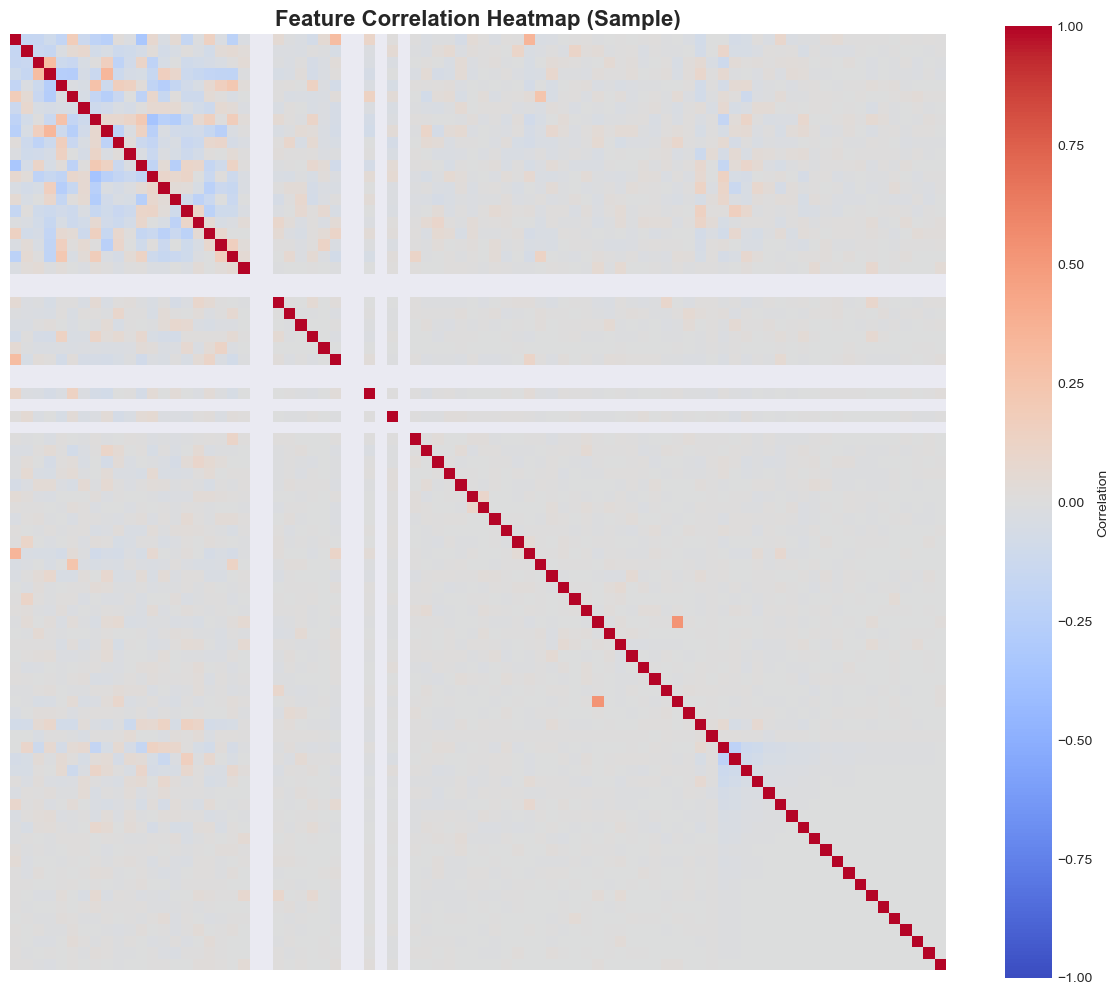

Correlation analysis hoàn tất!


In [21]:
# Correlation Analysis: Phân tích correlation giữa các features
# Mục tiêu: Identify highly correlated features và redundant features

print("="*60)
print("FEATURE CORRELATION ANALYSIS")
print("="*60)

# Tính correlation matrix (sử dụng sample để tăng tốc nếu dataset lớn)
SAMPLE_SIZE = 10000  # Sample size cho correlation analysis

if feature_matrix.shape[0] > SAMPLE_SIZE:
    print(f"Dataset lớn ({feature_matrix.shape[0]:,} samples), sampling {SAMPLE_SIZE:,} samples cho correlation...")
    sample_indices = np.random.choice(feature_matrix.shape[0], SAMPLE_SIZE, replace=False)
    feature_sample = feature_matrix[sample_indices]
else:
    feature_sample = feature_matrix

print(f"\nTính correlation matrix cho {feature_sample.shape[0]:,} samples x {feature_sample.shape[1]:,} features...")

# Tính correlation matrix (Pearson correlation)
correlation_matrix = np.corrcoef(feature_sample.T)

print(f"Correlation matrix shape: {correlation_matrix.shape}")

# Phân tích correlation theo feature groups
feature_groups = {
    'AAC': (0, 20),
    'kmer3': (20, 20 + 4096),
    'kmer4': (20 + 4096, 20 + 4096 + 4096),
    'seq_features': (20 + 4096 + 4096, 20 + 4096 + 4096 + 2),
    'taxonomy': (20 + 4096 + 4096 + 2, feature_matrix.shape[1])
}

print("\n" + "="*60)
print("CORRELATION STATISTICS BY FEATURE GROUP")
print("="*60)

correlation_stats = {}

for group_name, (start_idx, end_idx) in feature_groups.items():
    group_corr = correlation_matrix[start_idx:end_idx, start_idx:end_idx]
    
    # Loại bỏ diagonal (self-correlation = 1)
    mask = ~np.eye(group_corr.shape[0], dtype=bool)
    group_corr_values = group_corr[mask]
    
    # Thống kê
    mean_corr = np.mean(np.abs(group_corr_values))
    max_corr = np.max(np.abs(group_corr_values))
    min_corr = np.min(np.abs(group_corr_values))
    high_corr_count = (np.abs(group_corr_values) > 0.8).sum()
    
    correlation_stats[group_name] = {
        'mean_abs_corr': mean_corr,
        'max_abs_corr': max_corr,
        'min_abs_corr': min_corr,
        'high_corr_count': high_corr_count,
        'total_pairs': len(group_corr_values)
    }
    
    print(f"\n{group_name} ({end_idx - start_idx} features):")
    print(f"  Mean absolute correlation: {mean_corr:.4f}")
    print(f"  Max absolute correlation: {max_corr:.4f}")
    print(f"  Min absolute correlation: {min_corr:.4f}")
    print(f"  Pairs với |corr| > 0.8: {high_corr_count:,} ({100*high_corr_count/len(group_corr_values):.2f}%)")

# Cross-group correlation analysis
# print("\n" + "="*60)
print("CROSS-GROUP CORRELATION ANALYSIS")
print("="*60)

group_names = list(feature_groups.keys())
for i, group1 in enumerate(group_names):
    for group2 in group_names[i+1:]:
        start1, end1 = feature_groups[group1]
        start2, end2 = feature_groups[group2]
        
        cross_corr = correlation_matrix[start1:end1, start2:end2]
        mean_cross_corr = np.mean(np.abs(cross_corr))
        max_cross_corr = np.max(np.abs(cross_corr))
        
        print(f"\n{group1} vs {group2}:")
        print(f"  Mean absolute correlation: {mean_cross_corr:.4f}")
        print(f"  Max absolute correlation: {max_cross_corr:.4f}")

# Identify highly correlated feature pairs
# print("\n" + "60"*"=")
print("HIGHLY CORRELATED FEATURE PAIRS")
print("="*60)

CORRELATION_THRESHOLD = 0.9
high_corr_pairs = []

# Chỉ check trong từng group để tránh quá nhiều pairs
for group_name, (start_idx, end_idx) in feature_groups.items():
    group_corr = correlation_matrix[start_idx:end_idx, start_idx:end_idx]
    
    # Tìm pairs với correlation cao
    for i in range(group_corr.shape[0]):
        for j in range(i+1, group_corr.shape[1]):
            corr_val = group_corr[i, j]
            if abs(corr_val) > CORRELATION_THRESHOLD:
                high_corr_pairs.append({
                    'group': group_name,
                    'feature1_idx': start_idx + i,
                    'feature2_idx': start_idx + j,
                    'correlation': corr_val
                })

print(f"\nTìm thấy {len(high_corr_pairs):,} feature pairs với |correlation| > {CORRELATION_THRESHOLD}")
if len(high_corr_pairs) > 0:
    print("\nTop 20 highly correlated pairs:")
    sorted_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)
    for pair in sorted_pairs[:20]:
        print(f"  Features {pair['feature1_idx']}-{pair['feature2_idx']} ({pair['group']}): {pair['correlation']:.4f}")

# Visualization: Correlation heatmap (sample của correlation matrix)
print("\n" + "="*60)
print("GENERATING CORRELATION HEATMAP")
print("="*60)

# Tạo heatmap cho một phần của correlation matrix (để visualization)
# Sample features để visualization
VISUALIZATION_SAMPLE = 100  # Số features để visualize

if feature_matrix.shape[1] > VISUALIZATION_SAMPLE:
    # Sample features từ mỗi group
    sampled_indices = []
    for group_name, (start_idx, end_idx) in feature_groups.items():
        group_size = end_idx - start_idx
        if group_size > 0:
            sample_size = min(VISUALIZATION_SAMPLE // len(feature_groups), group_size)
            group_indices = np.linspace(start_idx, end_idx-1, sample_size, dtype=int)
            sampled_indices.extend(group_indices)
    
    sampled_corr = correlation_matrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_labels = [f"F{i}" for i in sampled_indices]
else:
    sampled_corr = correlation_matrix
    sampled_labels = [f"F{i}" for i in range(feature_matrix.shape[1])]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sampled_corr, 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            xticklabels=False,
            yticklabels=False,
            cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap (Sample)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation analysis hoàn tất!")


## 12. Label Distribution Analysis


LABEL DISTRIBUTION ANALYSIS

1. LABEL DISTRIBUTION BY ASPECT
------------------------------------------------------------

P (Biological Process):
  Tổng số labels: 13,845,322.0
  Số unique labels: 25,221
  Trung bình labels/protein: 168.02
  Max labels/protein: 8308.0
  Frequency min: 5.0
  Frequency max: 6545.0
  Frequency median: 348.0
  Frequency mean: 549.0

F (Molecular Function):
  Tổng số labels: 33,263,405.0
  Số unique labels: 10,080
  Trung bình labels/protein: 403.66
  Max labels/protein: 7671.0
  Frequency min: 5.0
  Frequency max: 35146.0
  Frequency median: 184.0
  Frequency mean: 3299.9

C (Cellular Component):
  Tổng số labels: 29,172,750.0
  Số unique labels: 3,918
  Trung bình labels/protein: 354.02
  Max labels/protein: 3312.0
  Frequency min: 5.0
  Frequency max: 24839.0
  Frequency median: 9515.5
  Frequency mean: 7445.8

2. LABEL CO-OCCURRENCE ANALYSIS

P (Biological Process):
  Co-occurrence analysis (top 100 labels):
    Mean Jaccard similarity: 0.5285
    Max 

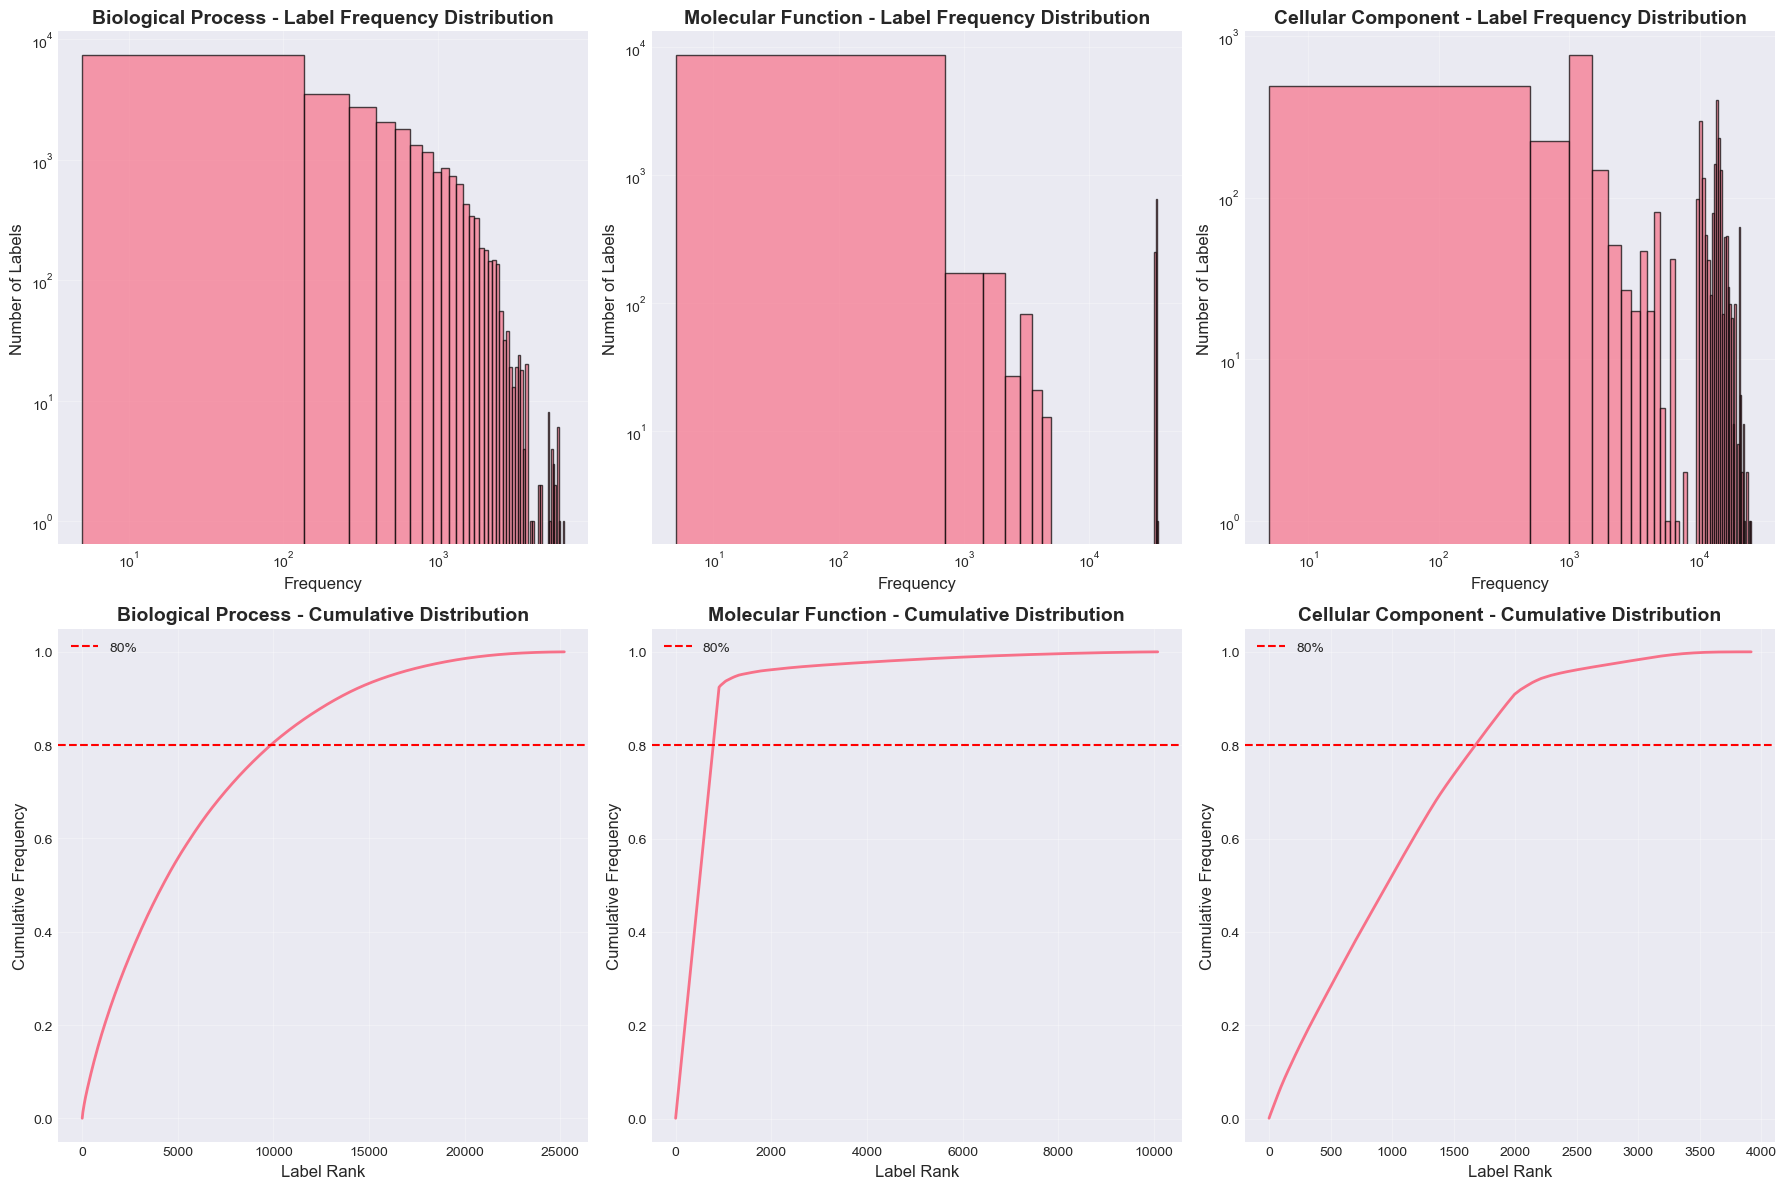


Label distribution analysis hoàn tất!


In [24]:
# Label Distribution Analysis: Phân tích phân phối labels
# Mục tiêu: Hiểu phân phối labels, co-occurrence patterns, rare vs common labels

print("="*60)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*60)

# 1. Phân tích phân phối labels theo aspect
print("\n1. LABEL DISTRIBUTION BY ASPECT")
print("-"*60)

label_distribution_stats = {}

for aspect_char in ['P', 'F', 'C']:
    label_matrix = label_matrices[aspect_char]
    
    # Tính frequency của mỗi label
    label_frequencies = np.array(label_matrix.sum(axis=0)).flatten()
    
    # Thống kê
    total_labels = label_frequencies.sum()
    unique_labels = (label_frequencies > 0).sum()
    mean_labels_per_protein = label_matrix.sum(axis=1).mean()
    max_labels_per_protein = label_matrix.sum(axis=1).max()
    
    label_distribution_stats[aspect_char] = {
        'label_frequencies': label_frequencies,
        'total_labels': total_labels,
        'unique_labels': unique_labels,
        'mean_labels_per_protein': mean_labels_per_protein,
        'max_labels_per_protein': max_labels_per_protein
    }
    
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Tổng số labels: {total_labels:,}")
    print(f"  Số unique labels: {unique_labels:,}")
    print(f"  Trung bình labels/protein: {mean_labels_per_protein:.2f}")
    print(f"  Max labels/protein: {max_labels_per_protein}")
    print(f"  Frequency min: {label_frequencies[label_frequencies > 0].min()}")
    print(f"  Frequency max: {label_frequencies.max()}")
    print(f"  Frequency median: {np.median(label_frequencies[label_frequencies > 0]):.1f}")
    print(f"  Frequency mean: {label_frequencies[label_frequencies > 0].mean():.1f}")

# 2. Label co-occurrence analysis
print("\n" + "="*60)
print("2. LABEL CO-OCCURRENCE ANALYSIS")
print("="*60)

# Tính co-occurrence matrix cho mỗi aspect (sample để tăng tốc)
CO_OCCURRENCE_SAMPLE = 5000  # Sample size cho co-occurrence

for aspect_char in ['P', 'F', 'C']:
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    
    label_matrix = label_matrices[aspect_char]
    
    # Sample proteins nếu cần
    if label_matrix.shape[0] > CO_OCCURRENCE_SAMPLE:
        sample_indices = np.random.choice(label_matrix.shape[0], CO_OCCURRENCE_SAMPLE, replace=False)
        label_matrix_sample = label_matrix[sample_indices]
    else:
        label_matrix_sample = label_matrix
    
    # Tính co-occurrence (chỉ cho top labels để tăng tốc)
    top_n_labels = 100
    label_freq = np.array(label_matrix_sample.sum(axis=0)).flatten()
    top_label_indices = np.argsort(label_freq)[-top_n_labels:]
    
    label_matrix_top = label_matrix_sample[:, top_label_indices].toarray()
    
    # Tính co-occurrence matrix
    co_occurrence = np.dot(label_matrix_top.T, label_matrix_top)
    
    # Normalize để có Jaccard similarity
    # label_counts[i] = số proteins có label i
    label_counts = label_matrix_top.sum(axis=0)  # shape: (top_n_labels,)
    # Jaccard(i,j) = co_occurrence[i,j] / (count_i + count_j - co_occurrence[i,j])
    # Sử dụng broadcasting: label_counts[i] + label_counts[j] cho tất cả pairs
    label_counts_i = label_counts[:, np.newaxis]  # shape: (top_n_labels, 1)
    label_counts_j = label_counts[np.newaxis, :]  # shape: (1, top_n_labels)
    jaccard_similarity = co_occurrence / (label_counts_i + label_counts_j - co_occurrence + 1e-8)
    
    # Thống kê
    mask = ~np.eye(jaccard_similarity.shape[0], dtype=bool)
    jaccard_values = jaccard_similarity[mask]
    
    print(f"  Co-occurrence analysis (top {top_n_labels} labels):")
    print(f"    Mean Jaccard similarity: {jaccard_values.mean():.4f}")
    print(f"    Max Jaccard similarity: {jaccard_values.max():.4f}")
    print(f"    Pairs với similarity > 0.5: {(jaccard_values > 0.5).sum():,}")

# 3. Rare vs Common labels analysis
print("\n" + "="*60)
print("3. RARE VS COMMON LABELS ANALYSIS")
print("="*60)

RARE_THRESHOLD = 10  # Labels với frequency < threshold được coi là rare
COMMON_THRESHOLD = 100  # Labels với frequency > threshold được coi là common

for aspect_char in ['P', 'F', 'C']:
    label_frequencies = label_distribution_stats[aspect_char]['label_frequencies']
    
    rare_labels = (label_frequencies > 0) & (label_frequencies < RARE_THRESHOLD)
    common_labels = label_frequencies >= COMMON_THRESHOLD
    medium_labels = (label_frequencies >= RARE_THRESHOLD) & (label_frequencies < COMMON_THRESHOLD)
    
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Rare labels (freq < {RARE_THRESHOLD}): {rare_labels.sum():,} ({100*rare_labels.sum()/len(label_frequencies):.1f}%)")
    print(f"  Medium labels ({RARE_THRESHOLD} <= freq < {COMMON_THRESHOLD}): {medium_labels.sum():,} ({100*medium_labels.sum()/len(label_frequencies):.1f}%)")
    print(f"  Common labels (freq >= {COMMON_THRESHOLD}): {common_labels.sum():,} ({100*common_labels.sum()/len(label_frequencies):.1f}%)")

# 4. Visualization: Label frequency distribution
print("\n" + "="*60)
print("4. GENERATING LABEL FREQUENCY VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, aspect_char in enumerate(['P', 'F', 'C']):
    label_frequencies = label_distribution_stats[aspect_char]['label_frequencies']
    label_frequencies_nonzero = label_frequencies[label_frequencies > 0]
    
    # Histogram (log scale)
    axes[0, idx].hist(label_frequencies_nonzero, bins=50, edgecolor='black', alpha=0.7)
    axes[0, idx].set_xlabel('Frequency', fontsize=12)
    axes[0, idx].set_ylabel('Number of Labels', fontsize=12)
    axes[0, idx].set_title(f'{aspect_map[aspect_char]} - Label Frequency Distribution', 
                          fontsize=14, fontweight='bold')
    axes[0, idx].set_yscale('log')
    axes[0, idx].set_xscale('log')
    axes[0, idx].grid(True, alpha=0.3)
    
    # Cumulative distribution
    sorted_freq = np.sort(label_frequencies_nonzero)[::-1]
    cumulative = np.cumsum(sorted_freq) / sorted_freq.sum()
    axes[1, idx].plot(range(len(cumulative)), cumulative, linewidth=2)
    axes[1, idx].set_xlabel('Label Rank', fontsize=12)
    axes[1, idx].set_ylabel('Cumulative Frequency', fontsize=12)
    axes[1, idx].set_title(f'{aspect_map[aspect_char]} - Cumulative Distribution', 
                          fontsize=14, fontweight='bold')
    axes[1, idx].grid(True, alpha=0.3)
    axes[1, idx].axhline(0.8, color='r', linestyle='--', label='80%')
    axes[1, idx].legend()

plt.tight_layout()
plt.show()

print("\nLabel distribution analysis hoàn tất!")


## 13. Feature Analysis


FEATURE ANALYSIS

1. FEATURE DISTRIBUTION ANALYSIS
------------------------------------------------------------

AAC (20 features):
  Mean of means: 0.050000
  Mean of stds: 0.021438
  Overall min: 0.000000
  Overall max: 0.725191
  Features với std = 0: 0

kmer3 (4096 features):
  Mean of means: 0.000244
  Mean of stds: 0.000861
  Overall min: 0.000000
  Overall max: 1.000000
  Features với std = 0: 572

kmer4 (4096 features):
  Mean of means: 0.000244
  Mean of stds: 0.000988
  Overall min: 0.000000
  Overall max: 0.500000
  Features với std = 0: 0

seq_features (2 features):
  Mean of means: 263.394110
  Mean of stds: 260.787391
  Overall min: 0.553539
  Overall max: 35213.000000
  Features với std = 0: 0

taxonomy (50 features):
  Mean of means: 0.018957
  Mean of stds: 0.089855
  Overall min: 0.000000
  Overall max: 1.000000
  Features với std = 0: 0

2. OUTLIER DETECTION

AAC:
  Tổng số outliers: 50,065
  Features có outliers: 20 (100.0%)
  Max outliers/feature: 4,573

kmer3:
  T

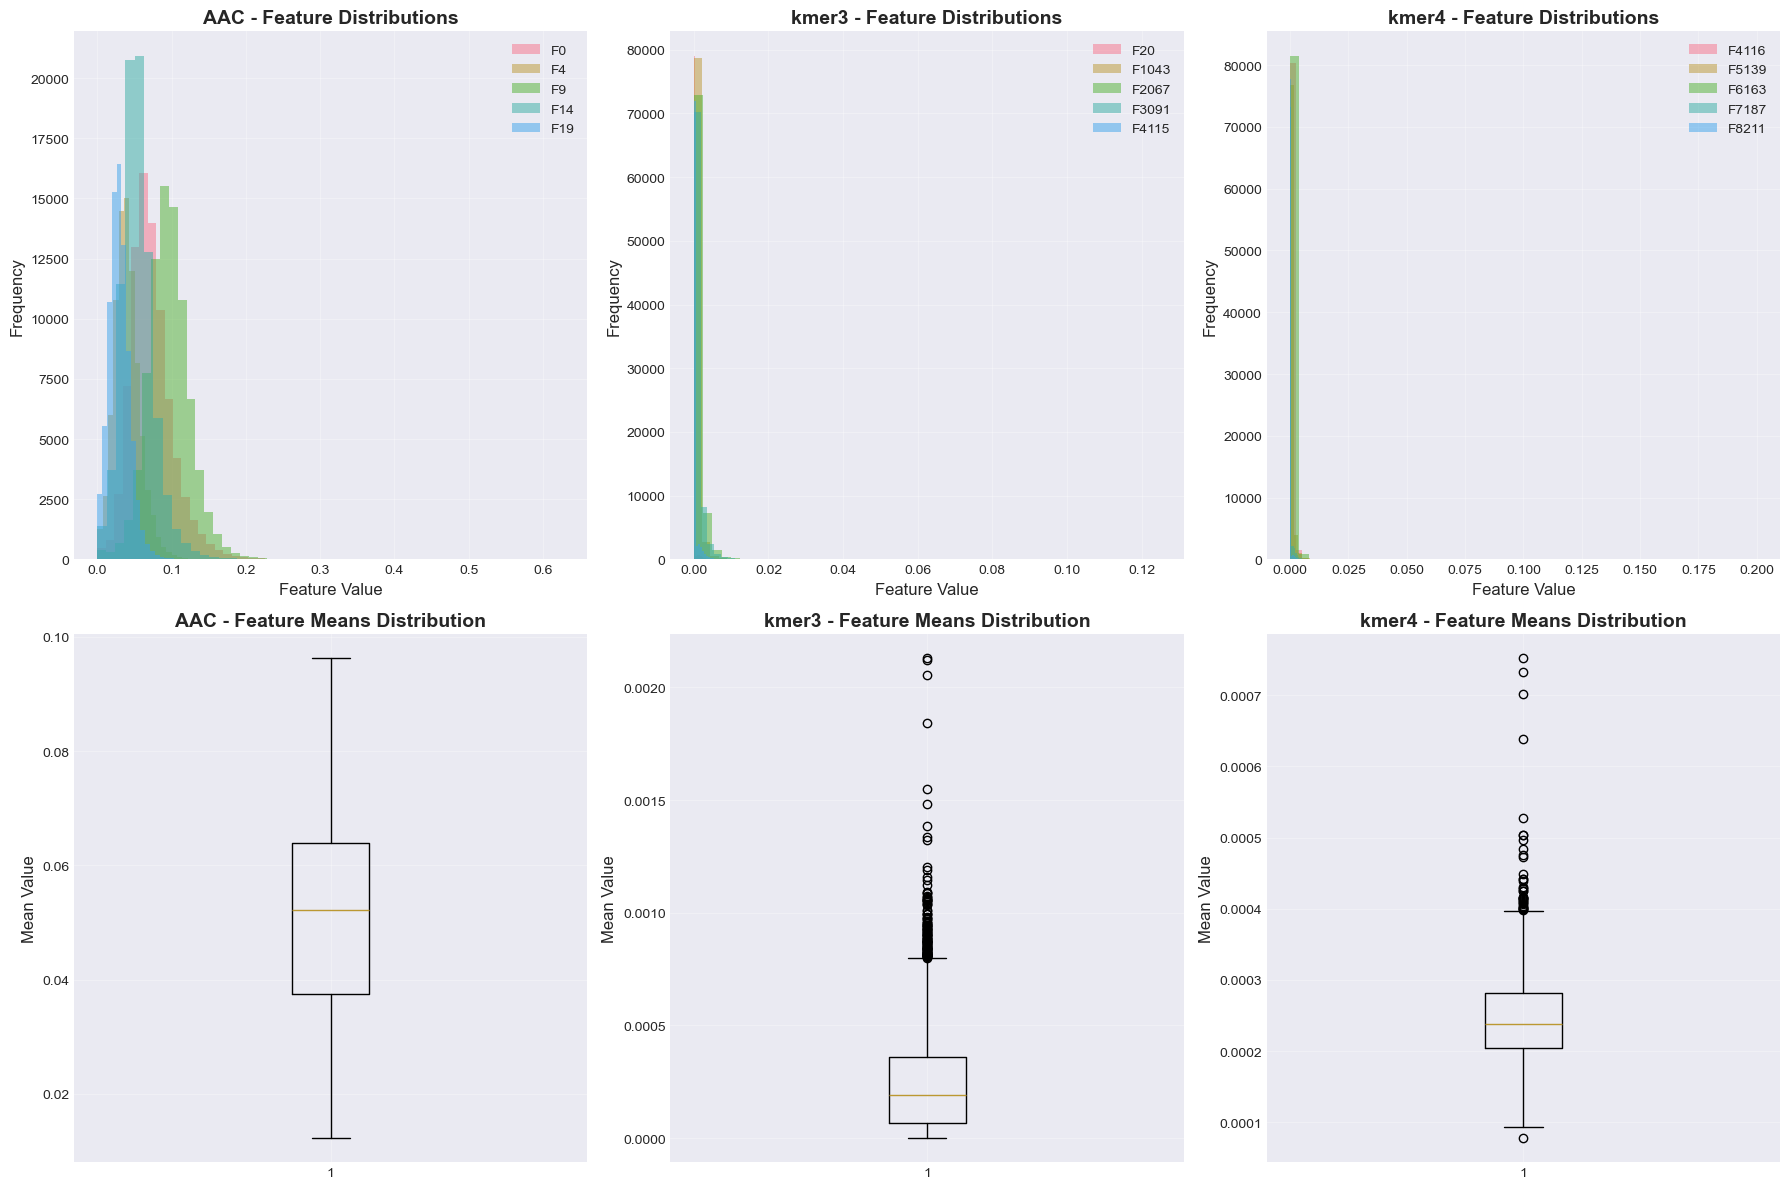


Feature analysis hoàn tất!


In [25]:
# Feature Analysis: Phân tích features, distribution, outliers
# Mục tiêu: Hiểu đặc tính của features và identify potential issues

print("="*60)
print("FEATURE ANALYSIS")
print("="*60)

# 1. Feature distribution analysis
print("\n1. FEATURE DISTRIBUTION ANALYSIS")
print("-"*60)

feature_distribution_stats = {}

for group_name, (start_idx, end_idx) in feature_groups.items():
    group_features = feature_matrix[:, start_idx:end_idx]
    
    # Thống kê
    mean_vals = group_features.mean(axis=0)
    std_vals = group_features.std(axis=0)
    min_vals = group_features.min(axis=0)
    max_vals = group_features.max(axis=0)
    
    feature_distribution_stats[group_name] = {
        'mean': mean_vals,
        'std': std_vals,
        'min': min_vals,
        'max': max_vals,
        'features': group_features
    }
    
    print(f"\n{group_name} ({end_idx - start_idx} features):")
    print(f"  Mean of means: {mean_vals.mean():.6f}")
    print(f"  Mean of stds: {std_vals.mean():.6f}")
    print(f"  Overall min: {min_vals.min():.6f}")
    print(f"  Overall max: {max_vals.max():.6f}")
    print(f"  Features với std = 0: {(std_vals == 0).sum()}")  # Constant features

# 2. Outlier detection
print("\n" + "="*60)
print("2. OUTLIER DETECTION")
print("="*60)

# Sử dụng IQR method để detect outliers
def detect_outliers_iqr(data, lower_percentile=25, upper_percentile=75, multiplier=1.5):
    """Detect outliers using IQR method"""
    q1 = np.percentile(data, lower_percentile, axis=0)
    q3 = np.percentile(data, upper_percentile, axis=0)
    iqr = q3 - q1
    
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers.sum(axis=0), lower_bound, upper_bound

outlier_stats = {}

for group_name, (start_idx, end_idx) in feature_groups.items():
    group_features = feature_matrix[:, start_idx:end_idx]
    
    outlier_counts, lower_bound, upper_bound = detect_outliers_iqr(group_features)
    
    total_outliers = outlier_counts.sum()
    features_with_outliers = (outlier_counts > 0).sum()
    max_outliers_per_feature = outlier_counts.max()
    
    outlier_stats[group_name] = {
        'outlier_counts': outlier_counts,
        'total_outliers': total_outliers,
        'features_with_outliers': features_with_outliers,
        'max_outliers_per_feature': max_outliers_per_feature
    }
    
    print(f"\n{group_name}:")
    print(f"  Tổng số outliers: {total_outliers:,}")
    print(f"  Features có outliers: {features_with_outliers} ({100*features_with_outliers/(end_idx-start_idx):.1f}%)")
    print(f"  Max outliers/feature: {max_outliers_per_feature:,}")

# 3. Feature correlation với labels (sample)
print("\n" + "="*60)
print("3. FEATURE-LABEL CORRELATION ANALYSIS")
print("="*60)

# Tính correlation giữa features và labels (sample để tăng tốc)
CORRELATION_SAMPLE = 5000

if feature_matrix.shape[0] > CORRELATION_SAMPLE:
    sample_indices = np.random.choice(feature_matrix.shape[0], CORRELATION_SAMPLE, replace=False)
    feature_sample = feature_matrix[sample_indices]
else:
    feature_sample = feature_matrix
    sample_indices = np.arange(feature_matrix.shape[0])

feature_label_corr = {}

for aspect_char in ['P', 'F', 'C']:
    label_matrix = label_matrices[aspect_char]
    label_sample = label_matrix[sample_indices].toarray()
    
    # Tính correlation giữa mỗi feature và mỗi label (sample labels)
    # Chỉ tính cho top labels để tăng tốc
    top_n_labels = 50
    label_freq = label_sample.sum(axis=0)
    top_label_indices = np.argsort(label_freq)[-top_n_labels:]
    label_sample_top = label_sample[:, top_label_indices]
    
    # Tính correlation
    corr_matrix = np.corrcoef(feature_sample.T, label_sample_top.T)
    feature_label_corr_matrix = corr_matrix[:feature_sample.shape[1], feature_sample.shape[1]:]
    
    # Thống kê
    max_corr_per_feature = np.max(np.abs(feature_label_corr_matrix), axis=1)
    mean_corr_per_feature = np.mean(np.abs(feature_label_corr_matrix), axis=1)
    
    feature_label_corr[aspect_char] = {
        'max_corr': max_corr_per_feature,
        'mean_corr': mean_corr_per_feature,
        'corr_matrix': feature_label_corr_matrix
    }
    
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Mean max correlation: {max_corr_per_feature.mean():.4f}")
    print(f"  Max correlation: {max_corr_per_feature.max():.4f}")
    print(f"  Features với max corr > 0.3: {(max_corr_per_feature > 0.3).sum()}")

# 4. Visualization: Feature distributions
print("\n" + "="*60)
print("4. GENERATING FEATURE DISTRIBUTION VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (group_name, (start_idx, end_idx)) in enumerate(list(feature_groups.items())[:3]):
    group_features = feature_matrix[:, start_idx:end_idx]
    
    # Sample một vài features để visualize
    n_features_to_plot = min(5, end_idx - start_idx)
    feature_indices = np.linspace(0, end_idx - start_idx - 1, n_features_to_plot, dtype=int)
    
    # Plot distribution của sample features
    for feat_idx in feature_indices:
        axes[0, idx].hist(group_features[:, feat_idx], bins=50, alpha=0.5, 
                         label=f'F{start_idx + feat_idx}')
    
    axes[0, idx].set_xlabel('Feature Value', fontsize=12)
    axes[0, idx].set_ylabel('Frequency', fontsize=12)
    axes[0, idx].set_title(f'{group_name} - Feature Distributions', 
                          fontsize=14, fontweight='bold')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Box plot của feature means
    mean_vals = group_features.mean(axis=0)
    axes[1, idx].boxplot(mean_vals)
    axes[1, idx].set_ylabel('Mean Value', fontsize=12)
    axes[1, idx].set_title(f'{group_name} - Feature Means Distribution', 
                          fontsize=14, fontweight='bold')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFeature analysis hoàn tất!")


## 14. Comprehensive Visualizations


COMPREHENSIVE VISUALIZATIONS

1. GO Terms Frequency Distribution...


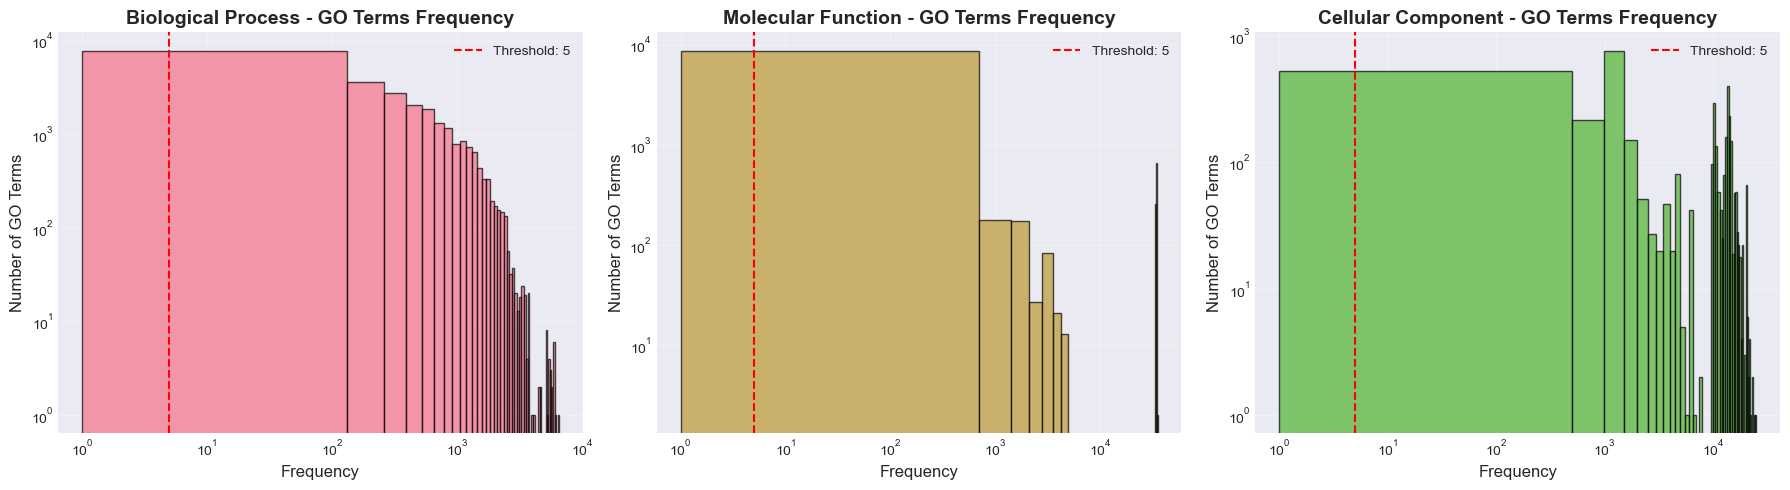


2. Label Co-occurrence Heatmap...


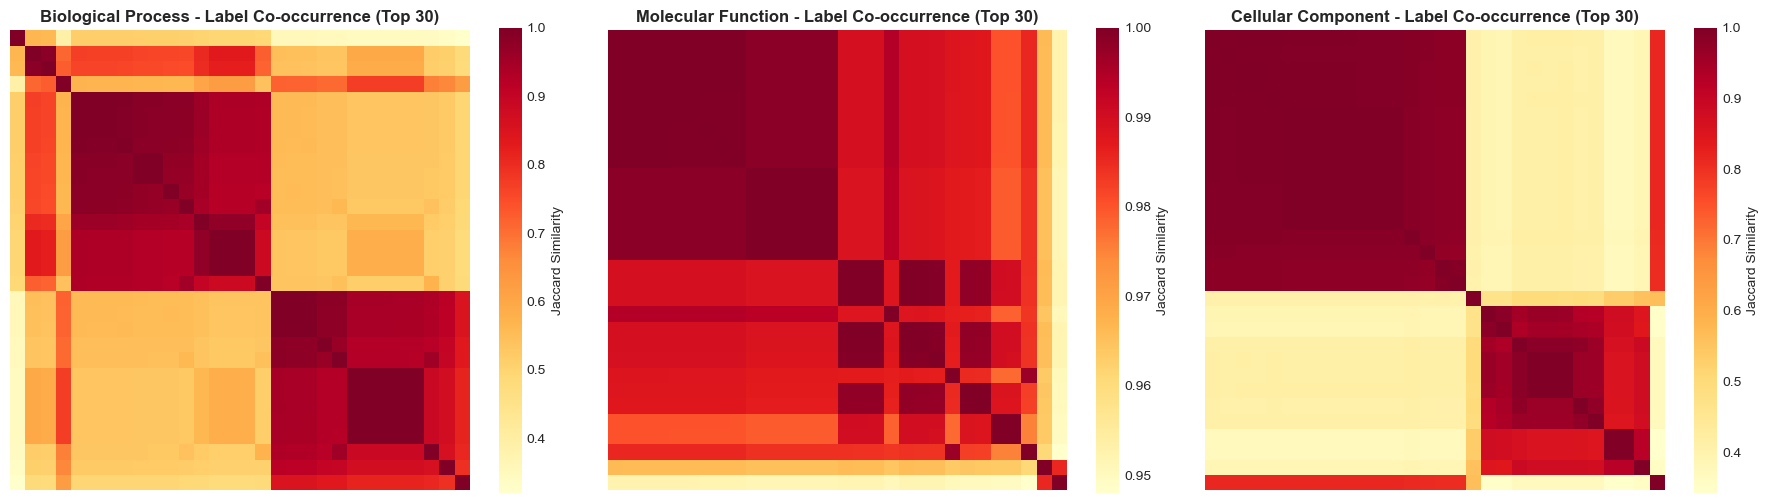


3. Taxonomy Distribution...


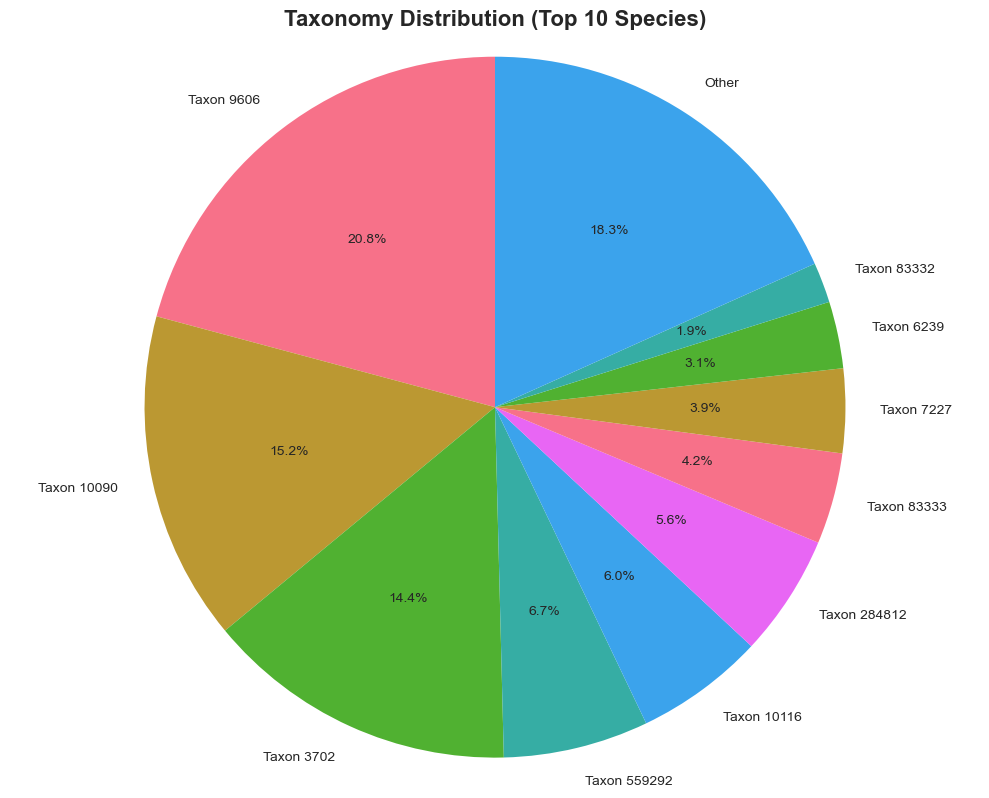


4. Feature Correlation Heatmap (Detailed)...


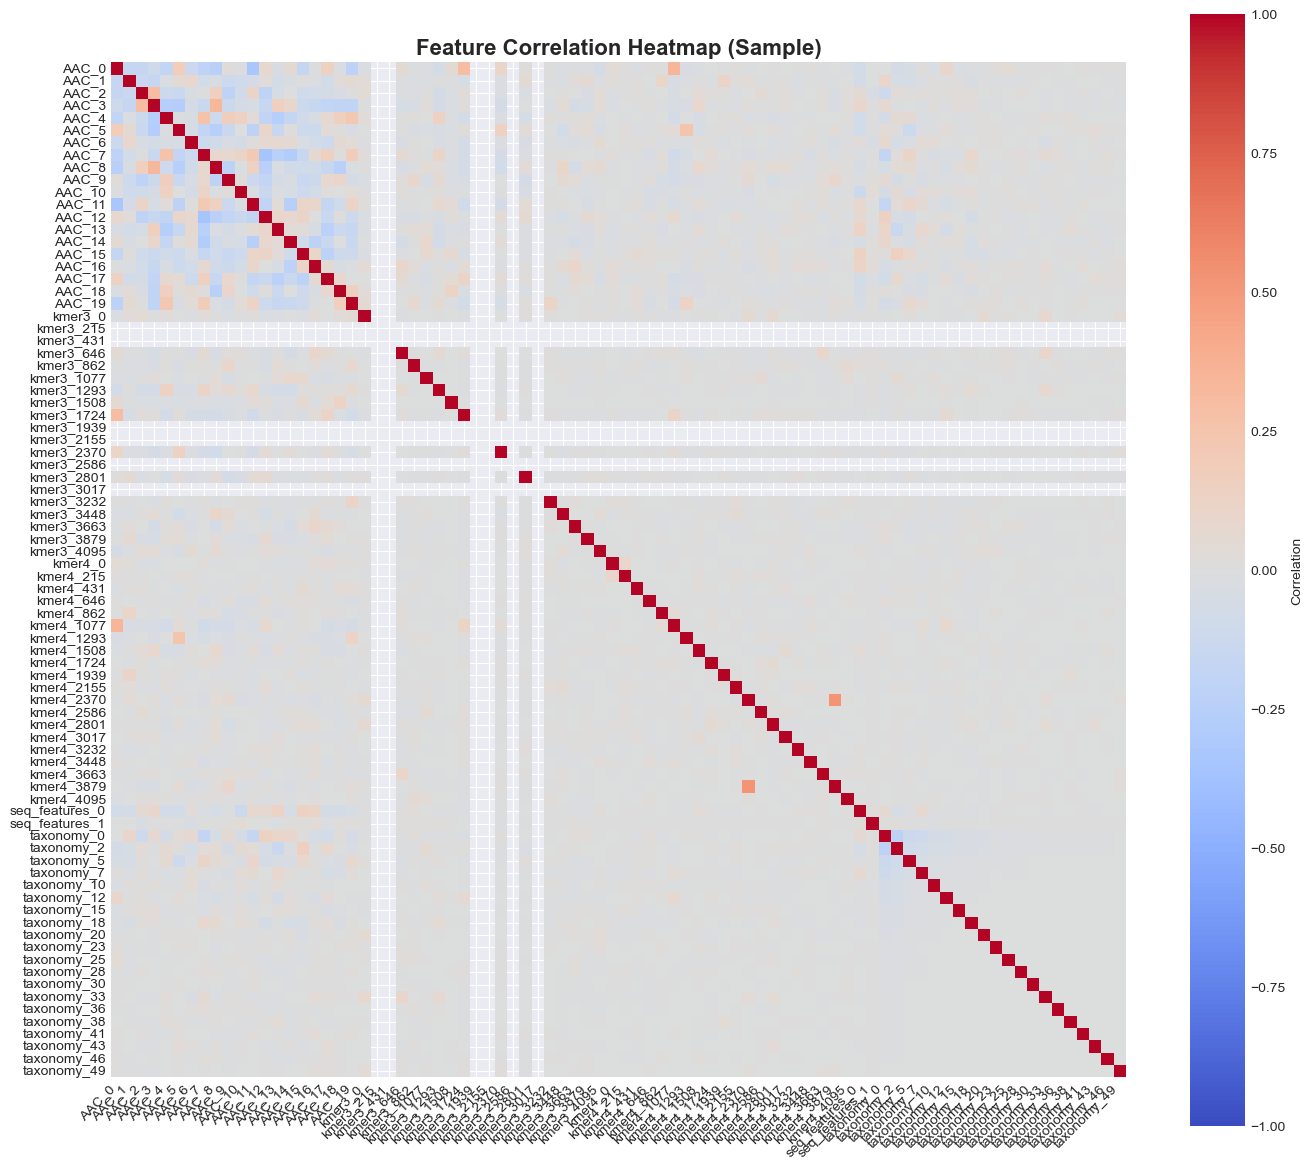


5. Label Distribution per Aspect...


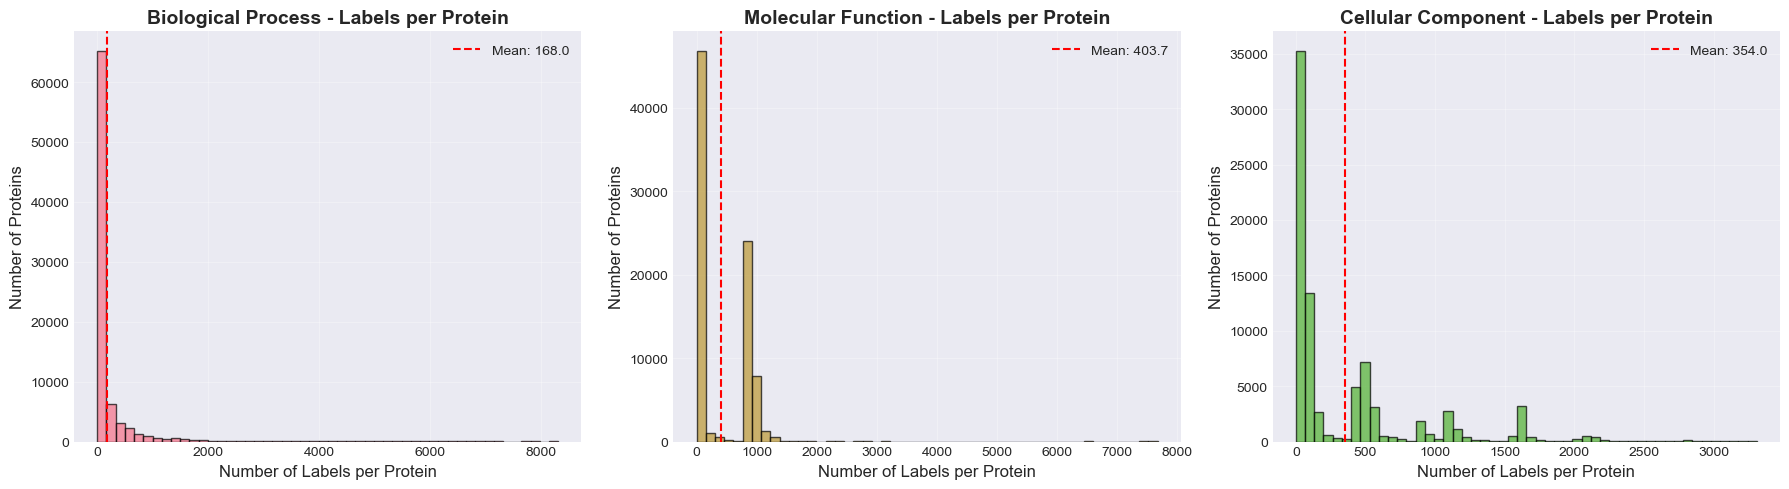


Comprehensive visualizations hoàn tất!


In [26]:
# Comprehensive Visualizations: Tổng hợp các visualizations quan trọng
# Mục tiêu: Tạo các biểu đồ tổng hợp để hiểu data tốt hơn

print("="*60)
print("COMPREHENSIVE VISUALIZATIONS")
print("="*60)

# 1. GO Terms Frequency Distribution (log scale)
print("\n1. GO Terms Frequency Distribution...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, aspect_char in enumerate(['P', 'F', 'C']):
    if 'frequency_stats' in locals() and aspect_char in frequency_stats:
        term_frequencies = frequency_stats[aspect_char]['term_frequencies']
    else:
        # Tính lại nếu chưa có
        aspect_labels = train_terms_propagated[
            train_terms_propagated['aspect'] == aspect_char
        ]
        term_frequencies = aspect_labels['term'].value_counts()
    
    # Plot với log scale
    axes[idx].hist(term_frequencies.values, bins=50, edgecolor='black', alpha=0.7, color=f'C{idx}')
    axes[idx].set_xlabel('Frequency', fontsize=12)
    axes[idx].set_ylabel('Number of GO Terms', fontsize=12)
    axes[idx].set_title(f'{aspect_map[aspect_char]} - GO Terms Frequency', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_yscale('log')
    axes[idx].set_xscale('log')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axvline(FREQUENCY_THRESHOLD, color='r', linestyle='--', 
                     label=f'Threshold: {FREQUENCY_THRESHOLD}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# 2. Label Co-occurrence Heatmap
print("\n2. Label Co-occurrence Heatmap...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, aspect_char in enumerate(['P', 'F', 'C']):
    label_matrix = label_matrices[aspect_char]
    
    # Sample và tính co-occurrence cho top labels
    top_n = 30
    label_freq = np.array(label_matrix.sum(axis=0)).flatten()
    top_indices = np.argsort(label_freq)[-top_n:]
    
    label_matrix_top = label_matrix[:, top_indices].toarray()
    co_occurrence = np.dot(label_matrix_top.T, label_matrix_top)
    
    # Normalize để có Jaccard similarity
    # label_counts[i] = số proteins có label i
    label_counts = label_matrix_top.sum(axis=0)  # shape: (top_n,)
    # Jaccard(i,j) = co_occurrence[i,j] / (count_i + count_j - co_occurrence[i,j])
    label_counts_i = label_counts[:, np.newaxis]  # shape: (top_n, 1)
    label_counts_j = label_counts[np.newaxis, :]  # shape: (1, top_n)
    jaccard = co_occurrence / (label_counts_i + label_counts_j - co_occurrence + 1e-8)
    
    # Plot heatmap
    sns.heatmap(jaccard, ax=axes[idx], cmap='YlOrRd', square=True,
                xticklabels=False, yticklabels=False, cbar_kws={'label': 'Jaccard Similarity'})
    axes[idx].set_title(f'{aspect_map[aspect_char]} - Label Co-occurrence (Top {top_n})', 
                       fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Taxonomy Distribution Pie Chart
print("\n3. Taxonomy Distribution...")

# Lấy top species
top_n_species_viz = 10
top_species_counts = taxonomy['taxon_id'].value_counts().head(top_n_species_viz)
other_count = taxonomy['taxon_id'].value_counts().iloc[top_n_species_viz:].sum()

# Tạo data cho pie chart
pie_data = list(top_species_counts.values) + [other_count]
pie_labels = [f'Taxon {idx}' for idx in top_species_counts.index] + ['Other']

plt.figure(figsize=(10, 8))
plt.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
plt.title('Taxonomy Distribution (Top 10 Species)', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 4. Feature Correlation Heatmap (đã làm ở trên, nhưng tạo lại với format đẹp hơn)
print("\n4. Feature Correlation Heatmap (Detailed)...")

# Sample features từ mỗi group
sample_per_group = 20
sampled_indices = []
sampled_labels = []

for group_name, (start_idx, end_idx) in feature_groups.items():
    group_size = end_idx - start_idx
    if group_size > 0:
        n_sample = min(sample_per_group, group_size)
        group_indices = np.linspace(start_idx, end_idx-1, n_sample, dtype=int)
        sampled_indices.extend(group_indices)
        sampled_labels.extend([f'{group_name}_{i-start_idx}' for i in group_indices])

sampled_corr = correlation_matrix[np.ix_(sampled_indices, sampled_indices)]

plt.figure(figsize=(14, 12))
sns.heatmap(sampled_corr, 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            xticklabels=sampled_labels,
            yticklabels=sampled_labels,
            cbar_kws={'label': 'Correlation'},
            fmt='.2f')
plt.title('Feature Correlation Heatmap (Sample)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Label Distribution per Aspect
print("\n5. Label Distribution per Aspect...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, aspect_char in enumerate(['P', 'F', 'C']):
    label_matrix = label_matrices[aspect_char]
    
    # Số labels per protein
    labels_per_protein = np.array(label_matrix.sum(axis=1)).flatten()
    
    axes[idx].hist(labels_per_protein, bins=50, edgecolor='black', alpha=0.7, color=f'C{idx}')
    axes[idx].set_xlabel('Number of Labels per Protein', fontsize=12)
    axes[idx].set_ylabel('Number of Proteins', fontsize=12)
    axes[idx].set_title(f'{aspect_map[aspect_char]} - Labels per Protein', 
                       fontsize=14, fontweight='bold')
    axes[idx].axvline(labels_per_protein.mean(), color='r', linestyle='--', 
                     label=f'Mean: {labels_per_protein.mean():.1f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComprehensive visualizations hoàn tất!")


## 15. Data Quality Report


In [27]:
# Data Quality Report: Tạo comprehensive report về data quality
# Mục tiêu: Document tất cả findings và preprocessing decisions

print("="*60)
print("GENERATING DATA QUALITY REPORT")
print("="*60)

report_lines = []
report_lines.append("="*80)
report_lines.append("DATA QUALITY REPORT")
report_lines.append("="*80)
report_lines.append(f"Generated: {pd.Timestamp.now()}")
report_lines.append("")

# 1. Dataset Overview
report_lines.append("1. DATASET OVERVIEW")
report_lines.append("-"*80)
report_lines.append(f"Total proteins: {len(valid_proteins):,}")
report_lines.append(f"Total features: {feature_matrix.shape[1]:,}")
report_lines.append(f"Feature breakdown:")
for group_name, (start_idx, end_idx) in feature_groups.items():
    report_lines.append(f"  - {group_name}: {end_idx - start_idx} features")
report_lines.append("")

# 2. Missing Values Summary
report_lines.append("2. MISSING VALUES SUMMARY")
report_lines.append("-"*80)

# Check missing values trong features
missing_in_features = np.isnan(feature_matrix).sum()
report_lines.append(f"Missing values in features: {missing_in_features:,}")
if missing_in_features > 0:
    report_lines.append(f"  Percentage: {100*missing_in_features/(feature_matrix.size):.4f}%")
else:
    report_lines.append("  ✓ No missing values in features")

# Check missing values trong labels
total_label_entries = sum(label_matrices[aspect].size for aspect in ['P', 'F', 'C'])
report_lines.append(f"Total label matrix entries: {total_label_entries:,}")
report_lines.append("  ✓ Labels are binary (0 or 1), no missing values")
report_lines.append("")

# 3. Outlier Summary
report_lines.append("3. OUTLIER SUMMARY")
report_lines.append("-"*80)

for group_name in feature_groups.keys():
    if group_name in outlier_stats:
        stats = outlier_stats[group_name]
        report_lines.append(f"{group_name}:")
        report_lines.append(f"  Total outliers: {stats['total_outliers']:,}")
        report_lines.append(f"  Features with outliers: {stats['features_with_outliers']}")
        report_lines.append(f"  Max outliers per feature: {stats['max_outliers_per_feature']:,}")
report_lines.append("")

# 4. Data Consistency Checks
report_lines.append("4. DATA CONSISTENCY CHECKS")
report_lines.append("-"*80)

# Check protein consistency
proteins_in_labels = set(train_terms_propagated['EntryID'].unique())
proteins_in_features = set(features_df['EntryID'].unique())
proteins_in_taxonomy = set(taxonomy['EntryID'].unique())

report_lines.append(f"Proteins in labels: {len(proteins_in_labels):,}")
report_lines.append(f"Proteins in features: {len(proteins_in_features):,}")
report_lines.append(f"Proteins in taxonomy: {len(proteins_in_taxonomy):,}")

if len(proteins_in_labels) == len(proteins_in_features) == len(proteins_in_taxonomy):
    report_lines.append("  ✓ All protein sets are consistent")
else:
    report_lines.append("  ⚠ Protein sets are inconsistent!")

# Check GO terms consistency
for aspect_char in ['P', 'F', 'C']:
    terms_in_labels = set(train_terms_propagated[
        train_terms_propagated['aspect'] == aspect_char
    ]['term'].unique())
    terms_in_matrix = set(label_indices[aspect_char].keys())
    
    if terms_in_labels == terms_in_matrix:
        report_lines.append(f"  ✓ {aspect_char} GO terms are consistent")
    else:
        report_lines.append(f"  ⚠ {aspect_char} GO terms are inconsistent!")
report_lines.append("")

# 5. Label Statistics
report_lines.append("5. LABEL STATISTICS")
report_lines.append("-"*80)

for aspect_char in ['P', 'F', 'C']:
    if aspect_char in label_distribution_stats:
        stats = label_distribution_stats[aspect_char]
        report_lines.append(f"{aspect_char} ({aspect_map[aspect_char]}):")
        report_lines.append(f"  Total labels: {stats['total_labels']:,}")
        report_lines.append(f"  Unique labels: {stats['unique_labels']:,}")
        report_lines.append(f"  Mean labels per protein: {stats['mean_labels_per_protein']:.2f}")
        report_lines.append(f"  Max labels per protein: {stats['max_labels_per_protein']}")
report_lines.append("")

# 6. Feature Statistics
report_lines.append("6. FEATURE STATISTICS")
report_lines.append("-"*80)

for group_name in feature_groups.keys():
    if group_name in feature_distribution_stats:
        stats = feature_distribution_stats[group_name]
        report_lines.append(f"{group_name}:")
        report_lines.append(f"  Mean of means: {stats['mean'].mean():.6f}")
        report_lines.append(f"  Mean of stds: {stats['std'].mean():.6f}")
        report_lines.append(f"  Overall min: {stats['min'].min():.6f}")
        report_lines.append(f"  Overall max: {stats['max'].max():.6f}")
        constant_features = (stats['std'] == 0).sum()
        if constant_features > 0:
            report_lines.append(f"  ⚠ Constant features: {constant_features}")
        else:
            report_lines.append(f"  ✓ No constant features")
report_lines.append("")

# 7. Frequency Filtering Summary
report_lines.append("7. FREQUENCY FILTERING SUMMARY")
report_lines.append("-"*80)

if 'frequency_stats' in locals():
    for aspect_char in ['P', 'F', 'C']:
        if aspect_char in frequency_stats:
            stats = frequency_stats[aspect_char]
            report_lines.append(f"{aspect_char} ({aspect_map[aspect_char]}):")
            report_lines.append(f"  Original GO terms: {stats['total_terms']:,}")
            report_lines.append(f"  After filtering (threshold={stats['threshold']}): {stats['terms_above_threshold']:,}")
            report_lines.append(f"  Removed: {stats['terms_below_threshold']:,} ({100*stats['terms_below_threshold']/stats['total_terms']:.1f}%)")
report_lines.append("")

# 8. Correlation Summary
report_lines.append("8. CORRELATION SUMMARY")
report_lines.append("-"*80)

if 'correlation_stats' in locals():
    for group_name in correlation_stats.keys():
        stats = correlation_stats[group_name]
        report_lines.append(f"{group_name}:")
        report_lines.append(f"  Mean absolute correlation: {stats['mean_abs_corr']:.4f}")
        report_lines.append(f"  Max absolute correlation: {stats['max_abs_corr']:.4f}")
        report_lines.append(f"  High correlation pairs (|corr| > 0.8): {stats['high_corr_count']:,}")
report_lines.append("")

# 9. Preprocessing Decisions
report_lines.append("9. PREPROCESSING DECISIONS")
report_lines.append("-"*80)
report_lines.append(f"Frequency threshold: {FREQUENCY_THRESHOLD}")
report_lines.append(f"Feature normalization: RobustScaler")
report_lines.append(f"Train/Val split: 80/20 (random_state=42)")
report_lines.append("")

# 10. Recommendations
report_lines.append("10. RECOMMENDATIONS")
report_lines.append("-"*80)

# Check for potential issues
if missing_in_features > 0:
    report_lines.append("  ⚠ Consider handling missing values in features")

constant_features_total = sum(
    (feature_distribution_stats[group]['std'] == 0).sum() 
    for group in feature_distribution_stats.keys()
)
if constant_features_total > 0:
    report_lines.append(f"  ⚠ Remove {constant_features_total} constant features")

if 'high_corr_pairs' in locals() and len(high_corr_pairs) > 1000:
    report_lines.append(f"  ⚠ Consider feature selection to reduce {len(high_corr_pairs)} highly correlated pairs")

report_lines.append("  ✓ Data quality is generally good")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("END OF REPORT")
report_lines.append("="*80)

# Print report
report_text = "\n".join(report_lines)
print(report_text)

# Save report to file
report_path = os.path.join(BASE_DIR, 'CleanData', 'data_quality_report.txt')
os.makedirs(os.path.dirname(report_path), exist_ok=True)

with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)

print(f"\n✓ Data quality report saved to: {report_path}")


GENERATING DATA QUALITY REPORT
DATA QUALITY REPORT
Generated: 2025-11-20 14:54:30.262925

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total proteins: 82,404
Total features: 8,264
Feature breakdown:
  - AAC: 20 features
  - kmer3: 4096 features
  - kmer4: 4096 features
  - seq_features: 2 features
  - taxonomy: 50 features

2. MISSING VALUES SUMMARY
--------------------------------------------------------------------------------
Missing values in features: 0
  ✓ No missing values in features
Total label matrix entries: 76,281,477
  ✓ Labels are binary (0 or 1), no missing values

3. OUTLIER SUMMARY
--------------------------------------------------------------------------------
AAC:
  Total outliers: 50,065
  Features with outliers: 20
  Max outliers per feature: 4,573
kmer3:
  Total outliers: 30,704,395
  Features with outliers: 3524
  Max outliers per feature: 20,595
kmer4:
  Total outliers: 37,885,794
  Features with outliers: 

## 16. Optional: Feature Selection


In [28]:
# Optional Feature Selection: Các phương pháp feature selection
# Mục tiêu: Giảm số lượng features và loại bỏ redundant features

print("="*60)
print("OPTIONAL FEATURE SELECTION")
print("="*60)
print("Note: Feature selection là optional, chỉ chạy nếu cần giảm số features")
print("")

# Import thêm các thư viện cần thiết
from sklearn.feature_selection import (
    VarianceThreshold, 
    SelectKBest, 
    f_classif,
    mutual_info_classif
)

# 1. Variance Threshold Filtering
print("1. VARIANCE THRESHOLD FILTERING")
print("-"*60)

VARIANCE_THRESHOLD = 0.01  # Features với variance < threshold sẽ bị loại

variance_selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD)

# Fit trên train features (chưa scaled để giữ variance gốc)
# Lưu ý: Nếu đã scale thì cần dùng feature_matrix gốc
try:
    # Sử dụng feature_matrix gốc nếu có, nếu không dùng train_features
    if 'train_features' in locals() and train_features.shape[0] > 0:
        # Nếu đã scale, cần dùng feature matrix gốc
        # Giả sử chúng ta có feature_matrix gốc
        variance_selector.fit(feature_matrix)
        selected_features_var = variance_selector.get_support()
        
        n_selected_var = selected_features_var.sum()
        n_removed_var = len(selected_features_var) - n_selected_var
        
        print(f"Variance threshold: {VARIANCE_THRESHOLD}")
        print(f"Selected features: {n_selected_var:,}")
        print(f"Removed features: {n_removed_var:,} ({100*n_removed_var/len(selected_features_var):.1f}%)")
        
        # Phân tích theo groups
        print("\nRemoved features by group:")
        for group_name, (start_idx, end_idx) in feature_groups.items():
            group_mask = selected_features_var[start_idx:end_idx]
            removed = (~group_mask).sum()
            print(f"  {group_name}: {removed} features removed")
    else:
        print("  ⚠ Feature matrix not available for variance analysis")
except Exception as e:
    print(f"  ⚠ Error in variance threshold filtering: {e}")

# 2. Correlation-based Feature Selection
print("\n" + "="*60)
print("2. CORRELATION-BASED FEATURE SELECTION")
print("="*60)

CORRELATION_THRESHOLD_FS = 0.95  # Loại bỏ features với correlation > threshold

def remove_highly_correlated_features(corr_matrix, threshold):
    """Remove features với correlation cao"""
    # Tạo mask để loại bỏ features
    to_remove = set()
    
    for i in range(corr_matrix.shape[0]):
        if i in to_remove:
            continue
        for j in range(i+1, corr_matrix.shape[1]):
            if abs(corr_matrix[i, j]) > threshold:
                # Loại bỏ feature có index cao hơn (giữ feature đầu tiên)
                to_remove.add(j)
    
    return to_remove

try:
    if 'correlation_matrix' in locals():
        # Sample correlation matrix nếu quá lớn
        if correlation_matrix.shape[0] > 1000:
            print("  Sampling features for correlation-based selection...")
            sample_size = 1000
            sample_indices = np.random.choice(correlation_matrix.shape[0], sample_size, replace=False)
            corr_sample = correlation_matrix[np.ix_(sample_indices, sample_indices)]
            to_remove_sample = remove_highly_correlated_features(corr_sample, CORRELATION_THRESHOLD_FS)
            print(f"  In sample: {len(to_remove_sample)} features would be removed")
        else:
            to_remove = remove_highly_correlated_features(correlation_matrix, CORRELATION_THRESHOLD_FS)
            print(f"Features to remove: {len(to_remove):,}")
            print(f"Remaining features: {correlation_matrix.shape[0] - len(to_remove):,}")
    else:
        print("  ⚠ Correlation matrix not available")
except Exception as e:
    print(f"  ⚠ Error in correlation-based selection: {e}")

# 3. Univariate Feature Selection
print("\n" + "="*60)
print("3. UNIVARIATE FEATURE SELECTION")
print("="*60)
print("Note: Univariate selection requires labels, sẽ tính cho từng aspect")
print("")

# Tính feature importance với univariate selection (sample để tăng tốc)
UNIVARIATE_SAMPLE = 5000
TOP_K_FEATURES = 1000  # Top K features để giữ lại

for aspect_char in ['P', 'F', 'C']:
    print(f"{aspect_char} ({aspect_map[aspect_char]}):")
    
    try:
        label_matrix = label_matrices[aspect_char]
        
        # Sample data nếu cần
        if feature_matrix.shape[0] > UNIVARIATE_SAMPLE:
            sample_indices = np.random.choice(feature_matrix.shape[0], UNIVARIATE_SAMPLE, replace=False)
            X_sample = feature_matrix[sample_indices]
            y_sample = label_matrix[sample_indices].toarray()
        else:
            X_sample = feature_matrix
            y_sample = label_matrix.toarray()
        
        # Tính feature importance với mutual information
        # Chỉ tính cho một label để tăng tốc (hoặc average)
        if y_sample.shape[1] > 1:
            # Sử dụng label phổ biến nhất
            label_freq = y_sample.sum(axis=0)
            top_label_idx = np.argmax(label_freq)
            y_single = y_sample[:, top_label_idx]
        else:
            y_single = y_sample.flatten()
        
        # Tính mutual information
        mi_scores = mutual_info_classif(X_sample, y_single, random_state=42, n_neighbors=3)
        
        # Top K features
        top_k_indices = np.argsort(mi_scores)[-TOP_K_FEATURES:]
        
        print(f"  Top {TOP_K_FEATURES} features by mutual information:")
        print(f"    Mean MI score: {mi_scores[top_k_indices].mean():.4f}")
        print(f"    Max MI score: {mi_scores.max():.4f}")
        
        # Phân tích top features theo groups
        print(f"  Top features by group:")
        for group_name, (start_idx, end_idx) in feature_groups.items():
            group_top = [idx for idx in top_k_indices if start_idx <= idx < end_idx]
            print(f"    {group_name}: {len(group_top)} features")
        
    except Exception as e:
        print(f"  ⚠ Error: {e}")

print("\n" + "="*60)
print("FEATURE SELECTION ANALYSIS HOÀN TẤT")
print("="*60)
print("\nLưu ý:")
print("- Feature selection là optional và có thể làm giảm performance")
print("- Nên test với model trước khi áp dụng feature selection")
print("- Có thể kết hợp nhiều phương pháp để có kết quả tốt nhất")


OPTIONAL FEATURE SELECTION
Note: Feature selection là optional, chỉ chạy nếu cần giảm số features

1. VARIANCE THRESHOLD FILTERING
------------------------------------------------------------
  ⚠ Feature matrix not available for variance analysis

2. CORRELATION-BASED FEATURE SELECTION
  Sampling features for correlation-based selection...
  In sample: 0 features would be removed

3. UNIVARIATE FEATURE SELECTION
Note: Univariate selection requires labels, sẽ tính cho từng aspect

P (Biological Process):
  Top 1000 features by mutual information:
    Mean MI score: 0.0063
    Max MI score: 0.0153
  Top features by group:
    AAC: 8 features
    kmer3: 507 features
    kmer4: 479 features
    seq_features: 2 features
    taxonomy: 4 features
F (Molecular Function):
  Top 1000 features by mutual information:
    Mean MI score: 0.0123
    Max MI score: 0.0794
  Top features by group:
    AAC: 9 features
    kmer3: 479 features
    kmer4: 501 features
    seq_features: 0 features
    taxono

## 10. IA Weights Integration

Số labels không có IA weight: 0

P (Biological Process):
  Mean IA weight: 1.2573
  Std IA weight: 2.2052
  Min IA weight: 0.0000
  Max IA weight: 12.8186

F (Molecular Function):
  Mean IA weight: 2.4776
  Std IA weight: 2.8944
  Min IA weight: 0.0000
  Max IA weight: 14.2128

C (Cellular Component):
  Mean IA weight: 2.4981
  Std IA weight: 3.3070
  Min IA weight: 0.0000
  Max IA weight: 13.7063

(25221,) class weights cho P

(10080,) class weights cho F

(3918,) class weights cho C


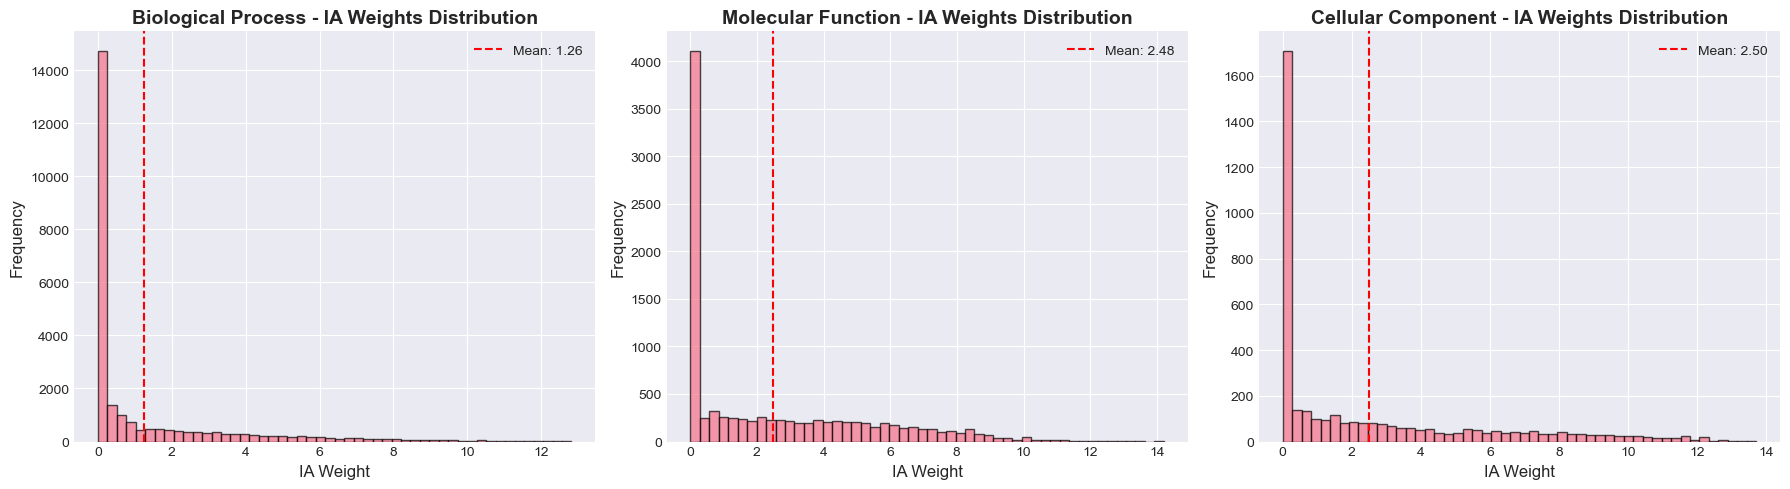

In [29]:
# Tích hợp IA weights vào preprocessing

# Load IA weights nếu chưa có (để đảm bảo có thể chạy cell độc lập)
try:
    _ = len(ia_weights)  # Kiểm tra ia_weights đã tồn tại chưa
except NameError:
    ia_file = os.path.join(BASE_DIR, 'IA.tsv')
    ia_weights = pd.read_csv(ia_file, sep='\t', header=None, names=['term', 'ia_weight'])
    print(f"Đã load IA weights: {len(ia_weights):,} entries")

# Merge IA weights với propagated labels
train_terms_with_ia = train_terms_propagated.merge(
    ia_weights, 
    left_on='term', 
    right_on='term', 
    how='left'
)

# Kiểm tra missing IA weights
missing_ia = train_terms_with_ia['ia_weight'].isna().sum()
print(f"Số labels không có IA weight: {missing_ia:,}")
if missing_ia > 0:
    # Fill missing với giá trị trung bình
    mean_ia = train_terms_with_ia['ia_weight'].mean()
    train_terms_with_ia['ia_weight'].fillna(mean_ia, inplace=True)
    print(f"Đã fill {missing_ia:,} missing values với mean IA weight: {mean_ia:.4f}")

# Tạo label weights cho mỗi aspect
label_weights = {}

for aspect_char in ['P', 'F', 'C']:
    aspect_terms = train_terms_with_ia[
        train_terms_with_ia['aspect'] == aspect_char
    ]
    
    # Tính average IA weight cho mỗi GO term
    term_ia_weights = aspect_terms.groupby('term')['ia_weight'].mean()
    
    # Tạo weight vector theo thứ tự của label_index
    weights = np.zeros(len(label_indices[aspect_char]))
    
    for term, ia_weight in term_ia_weights.items():
        if term in label_indices[aspect_char]:
            idx = label_indices[aspect_char][term]
            weights[idx] = ia_weight
    
    label_weights[aspect_char] = weights
    
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Mean IA weight: {weights.mean():.4f}")
    print(f"  Std IA weight: {weights.std():.4f}")
    print(f"  Min IA weight: {weights.min():.4f}")
    print(f"  Max IA weight: {weights.max():.4f}")

# Tính toán class weights cho loss function (inverse frequency weighted by IA)
class_weights = {}

for aspect_char in ['P', 'F', 'C']:
    label_matrix = label_matrices[aspect_char]
    ia_weights_vec = label_weights[aspect_char]
    
    # Tính frequency của mỗi label
    label_freq = np.array(label_matrix.sum(axis=0)).flatten()
    label_freq = label_freq / label_freq.sum()
    
    # Class weight = IA weight / frequency (normalized)
    # Labels hiếm và có IA cao sẽ có weight cao hơn
    class_w = ia_weights_vec / (label_freq + 1e-8)
    class_w = class_w / class_w.mean()  # Normalize
    
    class_weights[aspect_char] = class_w
    
    print(f"\n{class_weights[aspect_char].shape} class weights cho {aspect_char}")

# Visualization phân phối IA weights
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, aspect_char in enumerate(['P', 'F', 'C']):
    weights = label_weights[aspect_char]
    axes[idx].hist(weights, bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel('IA Weight', fontsize=12)
    axes[idx].set_ylabel('Frequency', fontsize=12)
    axes[idx].set_title(f'{aspect_map[aspect_char]} - IA Weights Distribution', 
                       fontsize=14, fontweight='bold')
    axes[idx].axvline(weights.mean(), color='r', linestyle='--', 
                     label=f'Mean: {weights.mean():.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()


## 11. Train/Validation Split

In [30]:
# 80/20 random train/val split

# Tạo protein indices
protein_indices = np.arange(len(features_df['EntryID']))

# Random split với random_state để reproducible
train_indices, val_indices = train_test_split(
    protein_indices,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Train set: {len(train_indices):,} proteins ({100*len(train_indices)/len(protein_indices):.1f}%)")
print(f"Validation set: {len(val_indices):,} proteins ({100*len(val_indices)/len(protein_indices):.1f}%)")

# Split features
train_features = feature_matrix[train_indices]
val_features = feature_matrix[val_indices]

print(f"\nTrain features shape: {train_features.shape}")
print(f"Val features shape: {val_features.shape}")

# Split labels cho mỗi aspect
train_labels = {}
val_labels = {}

for aspect_char in ['P', 'F', 'C']:
    label_matrix = label_matrices[aspect_char]
    
    train_labels[aspect_char] = label_matrix[train_indices]
    val_labels[aspect_char] = label_matrix[val_indices]
    
    print(f"\n{aspect_char} ({aspect_map[aspect_char]}):")
    print(f"  Train labels shape: {train_labels[aspect_char].shape}")
    print(f"  Val labels shape: {val_labels[aspect_char].shape}")
    
    # Thống kê phân phối labels
    train_label_counts = np.array(train_labels[aspect_char].sum(axis=0)).flatten()
    val_label_counts = np.array(val_labels[aspect_char].sum(axis=0)).flatten()
    
    print(f"  Train: {train_label_counts.sum():,} total labels, "
          f"{np.sum(train_label_counts > 0):,} unique labels")
    print(f"  Val: {val_label_counts.sum():,} total labels, "
          f"{np.sum(val_label_counts > 0):,} unique labels")

# Lưu train/val protein IDs
train_protein_ids = [features_df['EntryID'].iloc[idx] for idx in train_indices]
val_protein_ids = [features_df['EntryID'].iloc[idx] for idx in val_indices]


Train set: 65,923 proteins (80.0%)
Validation set: 16,481 proteins (20.0%)

Train features shape: (65923, 8264)
Val features shape: (16481, 8264)

P (Biological Process):
  Train labels shape: (65923, 25221)
  Val labels shape: (16481, 25221)
  Train: 11,012,924.0 total labels, 25,221 unique labels
  Val: 2,832,398.0 total labels, 25,074 unique labels

F (Molecular Function):
  Train labels shape: (65923, 10080)
  Val labels shape: (16481, 10080)
  Train: 26,547,680.0 total labels, 10,080 unique labels
  Val: 6,715,725.0 total labels, 10,071 unique labels

C (Cellular Component):
  Train labels shape: (65923, 3918)
  Val labels shape: (16481, 3918)
  Train: 23,187,228.0 total labels, 3,918 unique labels
  Val: 5,985,522.0 total labels, 3,917 unique labels


## 12. Feature Normalization

In [31]:
# Normalize features với RobustScaler (ít nhạy với outliers hơn StandardScaler)

scaler = RobustScaler()

# Fit trên train set
print("Đang fit scaler trên train set...")
scaler.fit(train_features)

# Transform cả train và val
print("Đang transform features...")
train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)

print(f"Train features scaled shape: {train_features_scaled.shape}")
print(f"Val features scaled shape: {val_features_scaled.shape}")

# Thống kê sau normalization
print("\nThống kê train features sau normalization:")
print(f"  Mean: {train_features_scaled.mean(axis=0).mean():.6f}")
print(f"  Std: {train_features_scaled.std(axis=0).mean():.6f}")
print(f"  Min: {train_features_scaled.min():.2f}")
print(f"  Max: {train_features_scaled.max():.2f}")

# Cập nhật feature matrices
train_features = train_features_scaled
val_features = val_features_scaled


Đang fit scaler trên train set...
Đang transform features...
Train features scaled shape: (65923, 8264)
Val features scaled shape: (16481, 8264)

Thống kê train features sau normalization:
  Mean: 0.028481
  Std: 0.068608
  Min: -2.78
  Max: 629.86


## 13. Save Processed Data

In [32]:
# Lưu processed data
# Tạo thư mục Code nếu chưa có
CODE_DIR = os.path.join(BASE_DIR, 'CleanData')
os.makedirs(CODE_DIR, exist_ok=True)

print("Đang lưu processed data...")

# 1. Lưu metadata vào pickle
metadata = {
    'label_indices': label_indices,
    'label_index_to_term': label_index_to_term,
    'protein_to_idx': protein_to_idx,
    'idx_to_protein': idx_to_protein,
    'train_indices': train_indices,
    'val_indices': val_indices,
    'train_protein_ids': train_protein_ids,
    'val_protein_ids': val_protein_ids,
    'label_weights': label_weights,
    'class_weights': class_weights,
    'scaler': scaler,
    'aspect_map': aspect_map,
    'root_terms': ROOT_TERMS,
    'top_species': top_species,
    'species_to_idx': species_to_idx,
    'feature_dim': feature_matrix.shape[1],
    'num_proteins': len(valid_proteins)
}

metadata_path = os.path.join(CODE_DIR, 'processed_data.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"✓ Đã lưu metadata: {metadata_path}")

# 2. Lưu features vào HDF5
features_path = os.path.join(CODE_DIR, 'features.h5')
with h5py.File(features_path, 'w') as f:
    f.create_dataset('train_features', data=train_features, compression='gzip')
    f.create_dataset('val_features', data=val_features, compression='gzip')
print(f"✓ Đã lưu features: {features_path}")

# 3. Lưu labels vào HDF5 (sparse matrices)
labels_path = os.path.join(CODE_DIR, 'labels.h5')
with h5py.File(labels_path, 'w') as f:
    for aspect_char in ['P', 'F', 'C']:
        # Convert sparse to dense để lưu vào HDF5
        train_labels_dense = train_labels[aspect_char].toarray()
        val_labels_dense = val_labels[aspect_char].toarray()
        
        f.create_dataset(f'train_labels_{aspect_char}', 
                        data=train_labels_dense, compression='gzip')
        f.create_dataset(f'val_labels_{aspect_char}', 
                        data=val_labels_dense, compression='gzip')
print(f"✓ Đã lưu labels: {labels_path}")

# 4. Lưu propagated labels
train_terms_path = os.path.join(CODE_DIR, 'train_terms_processed.pkl')
train_terms_propagated.to_pickle(train_terms_path)
print(f"✓ Đã lưu propagated labels: {train_terms_path}")

# 5. Lưu IA weights processed
ia_weights_processed = train_terms_with_ia[['term', 'aspect', 'ia_weight']].drop_duplicates()
ia_weights_path = os.path.join(CODE_DIR, 'ia_weights_processed.pkl')
ia_weights_processed.to_pickle(ia_weights_path)
print(f"✓ Đã lưu IA weights: {ia_weights_path}")

# Tạo summary report
print("\n" + "="*60)
print("SUMMARY REPORT")
print("="*60)
print(f"\nDataset Statistics:")
print(f"  Total proteins: {len(valid_proteins):,}")
print(f"  Train proteins: {len(train_indices):,}")
print(f"  Val proteins: {len(val_indices):,}")

print(f"\nFeature Statistics:")
print(f"  Feature dimensions: {feature_matrix.shape[1]:,}")
print(f"    - AAC: 20")
print(f"    - k-mer (k=3): 4096")
print(f"    - k-mer (k=4): 4096")
print(f"    - Sequence features: 2")
print(f"    - Taxonomy: {len(top_species)}")

print(f"\nLabel Statistics:")
for aspect_char in ['P', 'F', 'C']:
    num_labels = len(label_indices[aspect_char])
    train_total = train_labels[aspect_char].nnz
    val_total = val_labels[aspect_char].nnz
    print(f"  {aspect_char} ({aspect_map[aspect_char]}):")
    print(f"    - Total GO terms: {num_labels:,}")
    print(f"    - Train labels: {train_total:,}")
    print(f"    - Val labels: {val_total:,}")

print(f"\nFiles Saved:")
print(f"  - {metadata_path}")
print(f"  - {features_path}")
print(f"  - {labels_path}")
print(f"  - {train_terms_path}")
print(f"  - {ia_weights_path}")

print("\n" + "="*60)
print("Preprocessing hoàn tất! ✓")
print("="*60)


Đang lưu processed data...
✓ Đã lưu metadata: /Users/user/ML/CreatineML/CleanData/processed_data.pkl
✓ Đã lưu features: /Users/user/ML/CreatineML/CleanData/features.h5
✓ Đã lưu labels: /Users/user/ML/CreatineML/CleanData/labels.h5
✓ Đã lưu propagated labels: /Users/user/ML/CreatineML/CleanData/train_terms_processed.pkl
✓ Đã lưu IA weights: /Users/user/ML/CreatineML/CleanData/ia_weights_processed.pkl

SUMMARY REPORT

Dataset Statistics:
  Total proteins: 82,404
  Train proteins: 65,923
  Val proteins: 16,481

Feature Statistics:
  Feature dimensions: 8,264
    - AAC: 20
    - k-mer (k=3): 4096
    - k-mer (k=4): 4096
    - Sequence features: 2
    - Taxonomy: 50

Label Statistics:
  P (Biological Process):
    - Total GO terms: 25,221
    - Train labels: 11,012,924
    - Val labels: 2,832,398
  F (Molecular Function):
    - Total GO terms: 10,080
    - Train labels: 26,547,680
    - Val labels: 6,715,725
  C (Cellular Component):
    - Total GO terms: 3,918
    - Train labels: 23,187,22